## Data Wrangling/Cleaning

In [1]:
#import basic needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
#function to provide summary for each column as a dataframe. Thanks to my mentor Ajith Patnaik 
#for providing this code
def univariate_analysis(df):
    """

    :param df: pd.Dataframe containing all the attributes needed
    :return: Dataframe with summary statistics
    """
    df_copy = df.copy()
    row_count = df_copy.shape[0]
    dtype = df_copy.dtypes.reset_index()
    dtype_df= dtype.rename(columns = {'index': 'Column Name', 0: 'Dtype'})
    count_dict, describe_dict = dict(), dict()
    for idx, row in dtype_df.iterrows():
        col_data = df_copy[row['Column Name']]
        null_count = col_data.isnull().sum()
        zero_count = col_data[col_data == 0].shape[0]
        non_zero_count = row_count - null_count - zero_count
        s = df_copy[row['Column Name']].value_counts(dropna = False)
        unique,largest = s.shape[0], s.nlargest(n=1, keep='first')
        top, Freq = largest.index[0], largest.values[0]
        count_dict[row['Column Name']] = {'Non-Zero Count': non_zero_count, 'Null Count': null_count,
                                          'Zero Count': zero_count, 'Unique': unique, 'Top Value': top,
                                          'Top Freq': Freq}
        col_data_noNa = col_data.dropna()
        ser_sum = col_data_noNa.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])
        if col_data.dtype != 'object':
            ser_sum = np.round(ser_sum, decimals=4)
        describe_dict[row['Column Name']] = ser_sum.to_dict()
    count_df = pd.DataFrame.from_dict(count_dict, orient='index').reset_index().rename(columns={'index': 'Column Name'})
    describe_df = pd.DataFrame.from_dict(describe_dict, orient='index').reset_index().rename(columns={'index': 'Column Name'})
    if 'top' in describe_df.columns.tolist():
        describe_df = describe_df.drop(['top', 'unique', 'freq'], axis=1)
    merge_df = pd.merge(dtype_df, count_df, on='Column Name')
    final_df = pd.merge(merge_df, describe_df, on='Column Name')
    return final_df

In [3]:
#read in the data

#training data
df=pd.read_csv('lc_loan.csv/lc_loan.csv',low_memory=False)

#test data
df2=pd.read_csv('lc_2016_2017.csv/lc_2016_2017.csv',low_memory=False)

In [4]:
df_stats=univariate_analysis(df)

In [5]:
df_stats.head()

,Column Name,Dtype,Non-Zero Count,Null Count,Zero Count,Unique,Top Value,Top Freq,count,mean,...,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
0,id,int64,887379,0,0,887379,1077501,1,887379.0,3.246513e+07,...,476445.9,1090262.7,1944971.8,9206643.0,34433267.0,54908135.0,63285441.4,65754792.2,67819908.22,68617057.0
1,member_id,int64,887379,0,0,887379,1296599,1,887379.0,3.500182e+07,...,601782.5,1317185.3,1988500.6,10877133.5,37095283.0,58471347.0,67597478.6,70387497.7,72678208.52,73544841.0
2,loan_amnt,float64,887379,0,0,1372,10000.0,61837,887379.0,1.475526e+04,...,1800.0,3600.0,5000.0,8000.0,13000.0,20000.0,28000.0,32000.0,35000.00,35000.0
3,funded_amnt,float64,887379,0,0,1372,10000.0,61744,887379.0,1.474188e+04,...,1800.0,3600.0,5000.0,8000.0,13000.0,20000.0,27975.0,32000.0,35000.00,35000.0
4,funded_amnt_inv,float64,887146,0,233,9856,10000.0,56111,887379.0,1.470246e+04,...,1600.0,3500.0,5000.0,8000.0,13000.0,20000.0,27800.0,32000.0,35000.00,35000.0


In [6]:
#Write this to an excel file
df_stats.to_excel("dfstats.xlsx")

After writing this to a file we used that information to start an approach to cleaning and feature engineering

In [7]:
#Make new dataframes that we can clean while keeping the old ones in case
#we need something from them deleted initially
train_ids=df['id']
test_ids=df2['id']
#drop ids from test and train data 
X=df.drop(columns=['id','member_id'])
X2=df2.drop(columns=['id','member_id'])


In [8]:
#we can see where the most missing values are in the training data
df_stats.sort_values('Null Count',ascending=False).head(10)

,Column Name,Dtype,Non-Zero Count,Null Count,Zero Count,Unique,Top Value,Top Freq,count,mean,...,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
54,dti_joint,float64,509,886870,0,450,NaN,886870,509.0,18.3101,...,4.0256,7.492,9.558,13.2,17.61,22.65,28.606,31.198,35.4356,43.86
53,annual_inc_joint,float64,511,886868,0,309,NaN,886868,511.0,109981.0116,...,29779.2000,47488.000,56000.000,76032.5,101771.00,132800.00,175000.000,190650.000,270000.0000,500000.00
55,verification_status_joint,object,511,886868,0,4,NaN,886868,511.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,il_util,float64,18479,868762,138,1273,NaN,868762,18617.0,71.5353,...,5.2000,27.800,40.360,58.6,74.90,87.60,96.800,100.700,117.4840,223.30
63,mths_since_rcnt_il,float64,20797,866569,13,202,NaN,866569,20810.0,20.9127,...,1.0000,2.000,3.000,6.0,12.00,23.00,48.000,83.000,134.0000,363.00
59,open_acc_6m,float64,13126,866007,8246,14,NaN,866007,21372.0,1.1090,...,0.0000,0.000,0.000,0.0,1.00,2.00,3.000,3.000,5.0000,14.00
60,open_il_6m,float64,19058,866007,2314,36,NaN,866007,21372.0,2.9288,...,0.0000,0.000,0.000,1.0,2.00,4.00,6.000,9.000,16.0000,40.00
61,open_il_12m,float64,10566,866007,10806,13,NaN,866007,21372.0,0.7617,...,0.0000,0.000,0.000,0.0,0.00,1.00,2.000,3.000,4.0000,12.00
62,open_il_24m,float64,15891,866007,5481,18,NaN,866007,21372.0,1.6746,...,0.0000,0.000,0.000,0.0,1.00,2.00,4.000,5.000,7.0000,19.00
64,total_bal_il,float64,19113,866007,2259,17031,NaN,866007,21372.0,36552.8114,...,0.0000,0.000,0.000,10251.5,24684.50,47858.00,81851.100,113323.300,204248.9300,878459.00


In [9]:
#We can see that there are many missing values related to joint applications
print(X.application_type.value_counts())
print(X2.application_type.value_counts())

INDIVIDUAL    886868
JOINT            511
Name: application_type, dtype: int64
Individual    725335
Joint App      34003
Name: application_type, dtype: int64


In [10]:
#For future potential use we change these so they are the same values in both
X2.application_type.replace({"Individual": "INDIVIDUAL", "Joint App": "JOINT"},inplace=True)
X2.application_type.value_counts()

INDIVIDUAL    725335
JOINT          34003
Name: application_type, dtype: int64

There are 3 other columns related to joint applications. We will try to combine these with the equivalent columns for non-joint applications


In [11]:
#We want to verify that the missing data in the joint features are only for individual applications
print(X[X.dti_joint.notnull()].application_type.value_counts())
print(X[X.annual_inc_joint.notnull()].application_type.value_counts())
print(X[X.verification_status_joint.notnull()].application_type.value_counts())

JOINT    509
Name: application_type, dtype: int64
JOINT    511
Name: application_type, dtype: int64
JOINT    511
Name: application_type, dtype: int64


For any missing of these we simply will copy the non-joint versions of these for now

In [12]:
X.dti_joint.fillna(X.dti,inplace=True)
X.annual_inc_joint.fillna(X.annual_inc,inplace=True)
X.verification_status_joint.fillna(X.verification_status,inplace=True)

In [13]:
X[X.application_type=="JOINT"][["dti_joint","dti","annual_inc","annual_inc_joint","verification_status","verification_status_joint"]].head()

,dti_joint,dti,annual_inc,annual_inc_joint,verification_status,verification_status_joint
466289,13.85,10.78,63000.00,71000.00,Not Verified,Not Verified
466419,16.40,20.67,75000.00,100000.00,Not Verified,Not Verified
466741,15.40,17.56,65000.00,77000.00,Source Verified,Not Verified
466850,22.76,22.70,96000.00,117000.00,Verified,Not Verified
466914,17.07,46.71,29524.32,94348.32,Verified,Not Verified


In [14]:
X[X.application_type=="INDIVIDUAL"][["dti_joint","dti","annual_inc","annual_inc_joint","verification_status","verification_status_joint"]].head()

,dti_joint,dti,annual_inc,annual_inc_joint,verification_status,verification_status_joint
0,27.65,27.65,24000.0,24000.0,Verified,Verified
1,1.00,1.00,30000.0,30000.0,Source Verified,Source Verified
2,8.72,8.72,12252.0,12252.0,Not Verified,Not Verified
3,20.00,20.00,49200.0,49200.0,Source Verified,Source Verified
4,17.94,17.94,80000.0,80000.0,Source Verified,Source Verified


In [15]:
print(X.dti.isna().sum(),X2.dti.isna().sum())

0 355


In [16]:
#No missing dti in main data set, but some missing in the test. Let's see what those are like
X2[X2.dti.isna()].application_type.value_counts()

JOINT    355
Name: application_type, dtype: int64

In [17]:
#Lets make sure those have joint dti information. If not we will have to impute values to both
X2[X2.dti.isna()].dti_joint.isna().sum()

0

In [18]:
#No applications missing both dti and joint dti. General strategy will be to replace missing values for one with the other
X2.dti.fillna(X2.dti_joint,inplace=True)

In [19]:
#We can see this simply duplicated the columns for the individual applications while not affecting the joint applications
#We do the same for the test data
X2.dti_joint.fillna(X2.dti,inplace=True)
X2.annual_inc_joint.fillna(X2.annual_inc,inplace=True)
X2.verification_status_joint.fillna(X2.verification_status,inplace=True)

Issue date, last credit pull date, last payment date ,earliest credit line, next payment date are strings, but will be more useful as datetime objects

In [20]:
X.issue_d=pd.to_datetime(X.issue_d)
X.last_credit_pull_d=pd.to_datetime(X.last_credit_pull_d)
X.last_pymnt_d=pd.to_datetime(X.last_pymnt_d)
X.earliest_cr_line=pd.to_datetime(X.earliest_cr_line)
X2.issue_d=pd.to_datetime(X2.issue_d)
X2.last_credit_pull_d=pd.to_datetime(X2.last_credit_pull_d)
X2.last_pymnt_d=pd.to_datetime(X2.last_pymnt_d)
X2.earliest_cr_line=pd.to_datetime(X2.earliest_cr_line)
X.next_pymnt_d=pd.to_datetime(X.next_pymnt_d)



In [21]:
X2.next_pymnt_d.value_counts()

Jan-2018    591170
Dec-2017       157
Feb-2018        96
Name: next_pymnt_d, dtype: int64

In [22]:
#need to replace the format of dates in the X2 data frame for the next_pymnt_d column before converting to datetime objects
X2.next_pymnt_d.replace({"Jan-2018":"2018-01-01","Dec-2017":"2017-12-01","Feb-2018":"2018-02-01"},inplace=True)
X2.next_pymnt_d=pd.to_datetime(X.next_pymnt_d)

To avoid dependency on issue date as that will change significantly over time we convert to timedeltas

In [23]:
X["last_credit_pull_td"]=X.last_credit_pull_d-X.issue_d
X2["last_credit_pull_td"]=X2.last_credit_pull_d-X.issue_d
X["last_pymnt_td"]=X.last_pymnt_d-X.issue_d
X2["last_pymnt_td"]=X2.last_pymnt_d-X.issue_d
X["earliest_cr_line_td"]=X.issue_d-X.earliest_cr_line
X2["earliest_cr_line_td"]=X2.issue_d-X2.earliest_cr_line
X["next_pymnt_td"]=X.next_pymnt_d-X.issue_d
X2["next_pymnt_td"]=X2.next_pymnt_d-X.issue_d

Now we drop the actual dates from the features

In [24]:
X.drop(columns=["issue_d","last_credit_pull_d","last_pymnt_d","earliest_cr_line","next_pymnt_d"],inplace=True)
X2.drop(columns=["issue_d","last_credit_pull_d","last_pymnt_d","earliest_cr_line","next_pymnt_d"],inplace=True)

We will now convert these to floating point numbers

In [25]:
X["last_credit_pull_d"]=X.last_credit_pull_td/pd.to_timedelta(1,'D')
X2["last_credit_pull_d"]=X2.last_credit_pull_td/pd.to_timedelta(1,'D')
X["last_pymnt_d"]=X.last_pymnt_td/pd.to_timedelta(1,'D')
X2["last_pymnt_d"]=X.last_pymnt_td/pd.to_timedelta(1,'D')
X["earliest_cr_line"]=X.earliest_cr_line_td/pd.to_timedelta(1,'D')
X2["earliest_cr_line"]=X.earliest_cr_line_td/pd.to_timedelta(1,'D')
X["next_pymnt_d"]=X.next_pymnt_td/pd.to_timedelta(1,'D')
X2["next_pymnt_d"]=X2.next_pymnt_td/pd.to_timedelta(1,'D')

We can now get rid of the timedelta features and leave the floating point ones.


In [26]:
X.drop(columns=["last_credit_pull_td","last_pymnt_td","earliest_cr_line_td","next_pymnt_td"],inplace=True)
X2.drop(columns=["last_credit_pull_td","last_pymnt_td","earliest_cr_line_td","next_pymnt_td"],inplace=True)

In [27]:
#drop the url feature
X.drop(columns=["url"],inplace=True)

In [28]:
set(X.columns).difference(set(X2.columns))

{'open_il_6m'}

In [29]:
set(X2.columns).difference(set(X.columns))

set()

In [30]:
#drop the column from the training data that the test data doesn't have
X.drop(columns=['open_il_6m'],inplace=True)

In [31]:
X.term.value_counts()

 36 months    621125
 60 months    266254
Name: term, dtype: int64

In [32]:
X2.term.value_counts()

36 months    561237
60 months    198101
Name: term, dtype: int64

In [33]:
#For now drop 'desc' featire
X.drop(columns=['desc'],inplace=True)
X2.drop(columns=['desc'],inplace=True)

At this point we have the columns we need in place. We will need to impute missing values and see how we want to use categorical data

In [34]:
#For employment will use "other" for missing values
X.emp_title.fillna("other",inplace=True)
X2.emp_title.fillna("other",inplace=True)

Employment length is a bit tricker as it's categorical but we want to have a median to put in for missing values

In [35]:
X.emp_length.value_counts()

10+ years    291569
2 years       78870
< 1 year      70605
3 years       70026
1 year        57095
5 years       55704
4 years       52529
7 years       44594
8 years       43955
6 years       42950
9 years       34657
Name: emp_length, dtype: int64

In [36]:
#Convert each of these to a numeric value, replacing <1 year with 0 and 10+ with 10
X.emp_length.replace({"10+ years":10,"2 years":2,"< 1 year":0,"3 years":3,"1 year":1,"5 years":5,"4 years":4,"7 years":7,"8 years":8,"6 years":6,"9 years":9},inplace=True)
X.emp_length.value_counts()

10.0    291569
2.0      78870
0.0      70605
3.0      70026
1.0      57095
5.0      55704
4.0      52529
7.0      44594
8.0      43955
6.0      42950
9.0      34657
Name: emp_length, dtype: int64

In [37]:
X2.emp_length.value_counts()

10+ years    257944
2 years       69494
< 1 year      62724
3 years       60843
1 year        50585
5 years       46139
4 years       45573
6 years       32616
8 years       28707
9 years       28554
7 years       25796
Name: emp_length, dtype: int64

In [38]:
#we will do the same with the test data
X2.emp_length.replace({"10+ years":10,"2 years":2,"< 1 year":0,"3 years":3,"1 year":1,"5 years":5,"4 years":4,"7 years":7,"8 years":8,"6 years":6,"9 years":9},inplace=True)
X2.emp_length.value_counts()

10.0    257944
2.0      69494
0.0      62724
3.0      60843
1.0      50585
5.0      46139
4.0      45573
6.0      32616
8.0      28707
9.0      28554
7.0      25796
Name: emp_length, dtype: int64

In [39]:
#We will use the median of the test data to impute. 
X.emp_length.median()

6.0

In [40]:
X.emp_length.fillna(6,inplace=True)
X2.emp_length.fillna(6,inplace=True)

In [41]:
X.annual_inc.describe()

count    8.873750e+05
mean     7.502759e+04
std      6.469830e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64

In [42]:
X.annual_inc.median()

65000.0

In [43]:
X.annual_inc.fillna(65000,inplace=True)
X2.annual_inc.fillna(65000,inplace=True)

In [44]:
X.title.value_counts()

Debt consolidation                     414001
Credit card refinancing                164331
Home improvement                        40112
Other                                   31892
Debt Consolidation                      15760
                                        ...  
New Heater                                  1
Looking to get out of debt                  1
Debt Conso/Pay off initial LC loan          1
Emergency Home Repair                       1
Credit Card/Auto Repair                     1
Name: title, Length: 63144, dtype: int64

In [45]:
X.purpose.value_counts()

debt_consolidation    524215
credit_card           206182
home_improvement       51829
other                  42894
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

In [46]:
X.title.isna().sum()

152

In [47]:
X.purpose.isna().sum()

0

In [48]:
X2.title.isna().sum()

23173

In [49]:
X2.purpose.isna().sum()

0

In [50]:
#For title we use 'other' for missing values
X.title.fillna("other",inplace=True)
X2.title.fillna("other",inplace=True)

For entries about negative events in a time period we will fill those with 0, assuming that no information means those events did not occur

In [51]:
X.inq_last_6mths.fillna(0,inplace=True)
X.inq_last_12m.fillna(0,inplace=True)
X.inq_fi.fillna(0,inplace=True)
X.collections_12_mths_ex_med.fillna(0,inplace=True)
X.pub_rec.fillna(0,inplace=True)
X.acc_now_delinq.fillna(0,inplace=True)
X.delinq_2yrs.fillna(0,inplace=True)


In [52]:
X2.inq_last_6mths.fillna(0,inplace=True)
X2.inq_last_12m.fillna(0,inplace=True)
X2.inq_fi.fillna(0,inplace=True)
X2.collections_12_mths_ex_med.fillna(0,inplace=True)
X2.pub_rec.fillna(0,inplace=True)
X2.acc_now_delinq.fillna(0,inplace=True)
X2.delinq_2yrs.fillna(0,inplace=True)


In [53]:
X.all_util.describe()

count    21372.000000
mean        60.831939
std         20.013254
min          0.000000
25%         47.700000
50%         61.900000
75%         75.200000
max        151.400000
Name: all_util, dtype: float64

In [54]:
X.all_util.value_counts()

61.0     71
68.0     60
51.0     57
61.3     57
72.0     56
         ..
3.3       1
15.7      1
107.9     1
97.6      1
7.4       1
Name: all_util, Length: 1128, dtype: int64

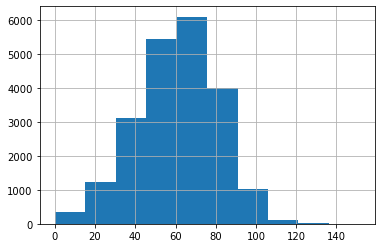

In [55]:
X.all_util.hist()
plt.show()

In [56]:
X.all_util.isna().sum()

866007

The distribution of utilization number is centered around 62%, however the vast majority have nothing put in, so this is a very small amount to generalize from. We might have to dig a little deeper to see if we can figure out what is going on

In [57]:
X.tot_cur_bal.describe()

count    8.171030e+05
mean     1.394582e+05
std      1.537500e+05
min      0.000000e+00
25%      2.985300e+04
50%      8.055900e+04
75%      2.082050e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

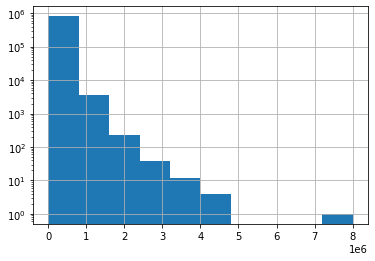

In [58]:
X.tot_cur_bal.hist(bins=10)
plt.yscale("log")
plt.show()

We save the columns as is elsewhere and for now use 0 to fill in missing values

In [59]:
tot_cur_bal=X.tot_cur_bal
all_util=X.all_util
X.all_util.fillna(0,inplace=True)
X.tot_cur_bal.fillna(0,inplace=True)

In [60]:
#Fill more zeros in for utilization ones
X.il_util.fillna(0,inplace=True)
X.total_cu_tl.fillna(0,inplace=True)
X.open_rv_12m.fillna(0,inplace=True)
X.open_rv_24m.fillna(0,inplace=True)

In [61]:
#Do the same to test data
tot_cur_bal2=X2.tot_cur_bal
all_util2=X2.all_util
X2.all_util.fillna(0,inplace=True)
X2.tot_cur_bal.fillna(0,inplace=True)
X2.il_util.fillna(0,inplace=True)
X2.total_cu_tl.fillna(0,inplace=True)
X2.open_rv_12m.fillna(0,inplace=True)
X2.open_rv_24m.fillna(0,inplace=True)

We use the median of the training data to fill in some fields

In [62]:
X.open_acc_6m.describe()

count    21372.000000
mean         1.109021
std          1.242675
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         14.000000
Name: open_acc_6m, dtype: float64

In [63]:
X.open_acc_6m.fillna(1,inplace=True)
X2.open_acc_6m.fillna(1,inplace=True)

In [64]:
X.open_il_12m.describe()

count    21372.000000
mean         0.761651
std          0.996035
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         12.000000
Name: open_il_12m, dtype: float64

In [65]:
X.open_il_12m.fillna(0,inplace=True)
X2.open_il_12m.fillna(0,inplace=True)

In [66]:
X.open_il_24m.describe()

count    21372.000000
mean         1.674574
std          1.688725
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: open_il_24m, dtype: float64

In [67]:
X.open_il_24m.fillna(1,inplace=True)
X2.open_il_24m.fillna(1,inplace=True)

In [68]:
X.tot_coll_amt.describe()

count    8.171030e+05
mean     2.257026e+02
std      1.031137e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64

In [69]:
X.tot_coll_amt.fillna(0,inplace=True)
X2.tot_coll_amt.fillna(0,inplace=True)

In [70]:
X.total_bal_il.fillna(0,inplace=True)
X2.total_bal_il.fillna(0,inplace=True)

In [71]:
X.tot_cur_bal.describe()

count    8.873790e+05
mean     1.284138e+05
std      1.522669e+05
min      0.000000e+00
25%      2.316800e+04
50%      6.533200e+04
75%      1.957940e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

In [72]:
X.tot_cur_bal.median()

65332.0

In [73]:
X.tot_cur_bal.fillna(65332,inplace=True)
X2.tot_cur_bal.fillna(65332,inplace=True)

In [74]:
X.total_rev_hi_lim.describe()

count    8.171030e+05
mean     3.206862e+04
std      3.749826e+04
min      0.000000e+00
25%      1.390000e+04
50%      2.370000e+04
75%      3.980000e+04
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64

In [75]:
X.total_rev_hi_lim.median()

23700.0

In [76]:
X.total_rev_hi_lim.fillna(23700,inplace=True)
X2.total_rev_hi_lim.fillna(23700,inplace=True)

In [77]:
X.revol_util.median()

56.0

In [78]:
X.revol_util.fillna(56,inplace=True)
X2.revol_util.fillna(56,inplace=True)

In [79]:
X.delinq_2yrs.fillna(0,inplace=True)
X2.delinq_2yrs.fillna(0,inplace=True)

In [80]:
X.open_acc.median()

11.0

In [81]:
X.open_acc.fillna(11,inplace=True)
X2.open_acc.fillna(11,inplace=True)

In [82]:
X.total_acc.describe()

count    887350.000000
mean         25.268026
std          11.840561
min           1.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         169.000000
Name: total_acc, dtype: float64

In [83]:
X.total_acc.fillna(24,inplace=True)
X2.total_acc.fillna(24,inplace=True)

For months since last derogatory action we will use 10000 to fill missing values for now (assuming they didn't occur). 

In [84]:
X.mths_since_last_delinq.fillna(10000, inplace=True)
X2.mths_since_last_delinq.fillna(10000, inplace=True)
X.mths_since_last_major_derog.fillna(10000,inplace=True)
X2.mths_since_last_major_derog.fillna(10000,inplace=True)
X.mths_since_last_record.fillna(10000,inplace=True)
X2.mths_since_last_record.fillna(10000,inplace=True)
X.mths_since_rcnt_il.fillna(10000,inplace=True)
X2.mths_since_rcnt_il.fillna(10000,inplace=True)

In [85]:
X.isna().sum()

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
                       ...  
inq_last_12m               0
last_credit_pull_d        53
last_pymnt_d           17659
earliest_cr_line          29
next_pymnt_d          252971
Length: 68, dtype: int64

All the time deltas we turned into numbers we replace missing values by the median of the training data

In [86]:
X.last_credit_pull_d.describe(datetime_is_numeric=True)

count    887326.000000
mean        472.719828
std         389.534823
min        -884.000000
25%         184.000000
50%         365.000000
75%         671.000000
max        3136.000000
Name: last_credit_pull_d, dtype: float64

In [87]:
X.last_credit_pull_d.fillna(365,inplace=True)
X2.last_credit_pull_d.fillna(365,inplace=True)

In [88]:
X.last_pymnt_d.describe()

count    869720.000000
mean        406.883764
std         310.310296
min           0.000000
25%         153.000000
50%         334.000000
75%         579.000000
max        2130.000000
Name: last_pymnt_d, dtype: float64

In [89]:
X.last_pymnt_d.fillna(334,inplace=True)
X2.last_pymnt_d.fillna(334,inplace=True)

In [90]:
X.earliest_cr_line.describe()

count    887350.000000
mean       5969.502444
std        2726.220517
min         184.000000
25%        4110.000000
50%        5419.000000
75%        7336.000000
max       25933.000000
Name: earliest_cr_line, dtype: float64

In [91]:
X.earliest_cr_line.fillna(5419,inplace=True)
X2.earliest_cr_line.fillna(5419,inplace=True)

In [92]:
X.next_pymnt_d.describe()

count    634408.000000
mean        387.325721
std         281.101808
min          31.000000
25%         153.000000
50%         306.000000
75%         549.000000
max        2010.000000
Name: next_pymnt_d, dtype: float64

In [93]:
X.next_pymnt_d.fillna(306,inplace=True)
X2.next_pymnt_d.fillna(306,inplace=True)

In [94]:
X.max_bal_bc.fillna(0,inplace=True)
X2.max_bal_bc.fillna(0,inplace=True)

In [95]:
#Lets see what is still missing values in each data set
for col in X.columns:
    if X[col].isna().sum()>0:
        print(col)

annual_inc_joint


In [96]:
#4 missing values here. Let's see what is going on in these
X[X.annual_inc_joint.isna()][["annual_inc","annual_inc_joint"]]

,annual_inc,annual_inc_joint
42449,65000.0,NaN
42450,65000.0,NaN
42480,65000.0,NaN
42533,65000.0,NaN


In [97]:
#These appear to be filled in values that were missing the annual income. We can just fill as before
X.annual_inc_joint.fillna(X.annual_inc,inplace=True)

In [98]:
#That took care of the last missing values in X. Let's look at X2
for col in X2.columns:
    if X2[col].isna().sum()>0:
        print(col)

zip_code


The zip code column in the test data is missing one value. Lets see what states these are in. 

In [99]:
X2.zip_code.isna().sum()

1

In [100]:
#One missing zip code. let's see what state it's in
X2[X2.zip_code.isna()].addr_state

187263    AL
Name: addr_state, dtype: object

In [101]:
#What zip codes do we have in AL?
X2[X2.addr_state=="AL"].zip_code.value_counts()

350xx    1001
352xx     969
365xx     817
351xx     772
357xx     577
368xx     560
360xx     557
366xx     516
356xx     501
363xx     433
361xx     395
358xx     394
359xx     390
354xx     358
362xx     338
355xx     208
364xx     147
367xx     135
369xx      28
640xx       1
091xx       1
300xx       1
307xx       1
802xx       1
184xx       1
969xx       1
750xx       1
220xx       1
902xx       1
441xx       1
326xx       1
721xx       1
325xx       1
250xx       1
852xx       1
324xx       1
980xx       1
287xx       1
857xx       1
995xx       1
191xx       1
319xx       1
483xx       1
240xx       1
951xx       1
337xx       1
890xx       1
925xx       1
112xx       1
134xx       1
315xx       1
096xx       1
251xx       1
294xx       1
941xx       1
Name: zip_code, dtype: int64

In [102]:
#Most common in AL was the 350xx zip code so we'll use that
X2.zip_code.fillna("350xx",inplace=True)

In [103]:
X2.isna().sum().max()

0

We now have no missing values in our data. We can create a target vector based on the values in the loan status column

In [104]:
X['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [105]:
X2['loan_status'].value_counts()

Current               565523
Fully Paid            130718
Charged Off            37197
Late (31-120 days)     15354
In Grace Period         6634
Late (16-30 days)       3876
Default                   36
Name: loan_status, dtype: int64

In [106]:
X2['loan_status'].unique()

array(['Current', 'Fully Paid', 'In Grace Period', 'Late (31-120 days)',
       'Late (16-30 days)', 'Charged Off', 'Default'], dtype=object)

In [107]:
#For each of the possible values of loan status , we put a 0 if favorable, 1 if unfavorable. 
#We any thing charged off, in default, or late more than a month unfavorable, otherwise favorable
values=[0,1,0,1,1,0,0,0,1,0]

In [108]:
#make a list of the values
keys=list(X['loan_status'].unique())

In [109]:
keys

['Fully Paid',
 'Charged Off',
 'Current',
 'Default',
 'Late (31-120 days)',
 'In Grace Period',
 'Late (16-30 days)',
 'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off',
 'Issued']

In [110]:
#make a dictionary mapping each value possible in loan status to a 0 or 1
dictionary=dict(zip(keys,values))

In [111]:
print(dictionary)

{'Fully Paid': 0, 'Charged Off': 1, 'Current': 0, 'Default': 1, 'Late (31-120 days)': 1, 'In Grace Period': 0, 'Late (16-30 days)': 0, 'Does not meet the credit policy. Status:Fully Paid': 0, 'Does not meet the credit policy. Status:Charged Off': 1, 'Issued': 0}


In [112]:
#replace the status with a 0 or 1 as appropriate
X['target']=X['loan_status'].map(dictionary)
X2['target']=X2['loan_status'].map(dictionary)
X.drop(columns=['loan_status'],inplace=True)
X2.drop(columns=['loan_status'],inplace=True)

We can see what percentage of loans are considered bad

In [113]:
print("The training data has ",X['target'].sum()/len(X['target'])*100,"% of loans that are bad")
print("The test data has ",X2['target'].sum()/len(X2['target'])*100,"% of loans that are bad")
print("There were ",X['target'].sum(), "bad loans in the training data")
print("There were ",X2['target'].sum(), "bad loans in the test data")

The training data has  6.628396660277063 % of loans that are bad
The test data has  6.925374470920723 % of loans that are bad
There were  58819 bad loans in the training data
There were  52587 bad loans in the test data


We have very unbalanced data here. When we actually go to model we will have to try to deal with this.

## Exploratory Data Analysis

Many of the features had almost all values missing. There's a very small positive class so we'll examine those to see how the positive class relates to those

In [114]:
#First we make a version of the target vector including the joint loans so we can compare to missing values. 
#we don't want to compare to filled values 
temp_target=df.loan_status.map(dictionary)
temp_target.head()


0    0
1    1
2    0
3    0
4    0
Name: loan_status, dtype: int64

In [115]:
#First the il_util column
df.il_util.isna().sum()

868762

In [116]:
temp_y=temp_target[df.il_util.notnull()]


In [117]:
temp_y.sum()

0

In [118]:
#Next the months since recent utilization of installment loan
temp_y=temp_target[df.mths_since_rcnt_il.notnull()]

In [119]:
temp_y.sum()

0

In [120]:
#Next the all_util column
temp_y=temp_target[df.all_util.notnull()]
temp_y.sum()

0

In [121]:
#Next the inq_fi column
temp_y=temp_target[df.inq_fi.notnull()]
temp_y.sum()

0

In [122]:
#next the inq_last_12m
temp_y=temp_target[df.inq_last_12m.notnull()]
temp_y.sum()

0

In [123]:
#next max_bal_bc column
temp_y=temp_target[df.max_bal_bc.notnull()]
temp_y.sum()

0

In [124]:
#next the open_acc_6m column
temp_y=temp_target[df.open_acc_6m.notnull()]
temp_y.sum()

0

In [125]:
#next the open_il_6m column
temp_y=temp_target[df.open_il_6m.notnull()]
temp_y.sum()

0

In [126]:
#next the open_il_12m column
temp_y=temp_target[df.open_il_12m.notnull()]
temp_y.sum()

0

In [127]:
#next the open_il_24m column
temp_y=temp_target[df.open_il_24m.notnull()]
temp_y.sum()

0

In [128]:
#next the open_rv_12m column
temp_y=temp_target[df.open_rv_12m.notnull()]
temp_y.sum()

0

In [129]:
temp_y=temp_target[df.inq_last_12m.notnull()]
temp_y.sum()

0

We are seeing a pattern here that many of these fields that had the vast majority of the entries missing had no members of the positive class when we did have information about them. This makes them feel dangerous to use as we could only make an intelligent guess as to what to put in. 

In [130]:
#We want to make a copy of the data. We keep the old copy with those columns in case
#we want to use them in the future
X_old=X
dropcols=[]
for col in X.columns:
    if col!="target":
            if df[col].isna().sum()>=860000:
                dropcols.append(col)

In [131]:
dropcols

['annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

These columns are mostly filled in and we saw that the ones with non-null values all were in the negative class. The actual values therefore aren't really useful to us, but it could be useful to know whether it was missing and how many of these were missing. We first replace the actual value of each one with a marker to indicate it was missing. We don't want to include the joint application data as we took care of that separately

In [132]:
dropcols.remove('annual_inc_joint')
dropcols.remove('dti_joint')
dropcols.remove('verification_status_joint')

In [133]:
#replace each of the remaining columns with a True/False depending on if they were null
for col in dropcols:
    X[col]=df[col].isna().astype(int)
    X2[col]=df2[col].isna().astype(int)

In [134]:
X[dropcols].head()

,open_acc_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m
0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1


In [135]:
X['missing_columns']=X[dropcols].sum(axis=1)
X2['missing_columns']=X2[dropcols].sum(axis=1)

In [136]:
X.missing_columns.head()

0    13
1    13
2    13
3    13
4    13
Name: missing_columns, dtype: int64

In [137]:
X.missing_columns.value_counts()

13    866007
0      18591
1       2245
2        536
Name: missing_columns, dtype: int64

In [138]:
#Now we can remove the individual ones
X.drop(columns=dropcols,inplace=True)
X2.drop(columns=dropcols,inplace=True)

In [139]:
#there were a few others with not quite as many missing values we can look at
temp_y=temp_target[df.mths_since_last_delinq.notnull()]
print(temp_y.sum())
temp_y=temp_target[df.tot_coll_amt.notnull()]
print(temp_y.sum())

27323
47900


Unlike the previous ones, the ones with actual information in them contain many positive class entries. We can see if the actual values they have seem to affect the outcome

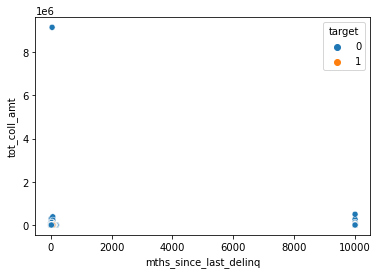

In [140]:
sns.scatterplot(x=X.mths_since_last_delinq,y=X.tot_coll_amt,hue=X.target)
plt.show()

In [141]:
#there is one outlier that is clearly skewing the picture so we can try to remove it#
X_outlier_removed=X[X.tot_coll_amt<X.tot_coll_amt.max()]

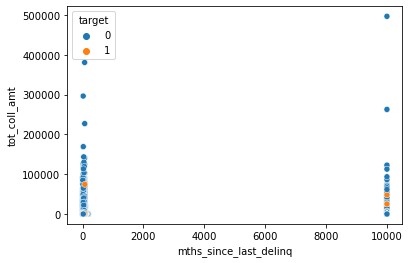

In [142]:
sns.scatterplot(x=X_outlier_removed.mths_since_last_delinq,y=X_outlier_removed.tot_coll_amt,hue=X_outlier_removed.target)
plt.show()

There is no obvious pattern but that one outlier definitely appears troubling. Let's see what that data point looks like

In [143]:
X[X.tot_coll_amt==X.tot_coll_amt.max()]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,last_credit_pull_d,last_pymnt_d,earliest_cr_line,next_pymnt_d,target,missing_columns
416962,10800.0,10800.0,10800.0,36 months,15.31,376.03,C,C4,Attorney,1.0,...,0.0,9152545.0,233924.0,13600.0,640.0,609.0,4292.0,306.0,0,13


This looks a bit odd, but as long as we stick to decision tree based algorithms, it's unlikely to throw things off. If we use anything that we need to normalize and attach weights, it might be best to throw out this outlier

Before looking at effects of DTI or income we want to make one column for each. For individuals this will be the same we had before, but for joint applications it will be the average

In [144]:
X.dti=(X.dti+X.dti_joint)/2
X2.dti=(X2.dti+X2.dti_joint)/2
X.annual_inc=(X.annual_inc+X.annual_inc_joint)/2
X2.annual_inc=(X2.annual_inc+X2.annual_inc_joint)/2

In [145]:
#Now we can drop the joint dti and joint income columns
X.drop(columns=['dti_joint','annual_inc_joint'],inplace=True)
X2.drop(columns=['dti_joint','annual_inc_joint'],inplace=True)

<AxesSubplot:xlabel='dti', ylabel='annual_inc'>

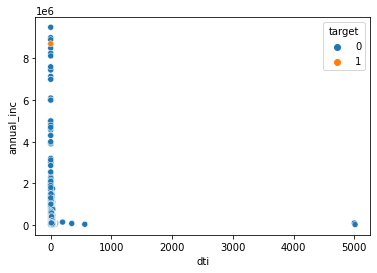

In [146]:
sns.scatterplot(data=X,x='dti',y='annual_inc',hue='target')

In [147]:
X.dti.describe()

count    887379.000000
mean         18.141741
std          11.203499
min           0.000000
25%          11.910000
50%          17.650000
75%          23.940000
max        5013.860000
Name: dti, dtype: float64

In [148]:
X[X.dti>1000].shape

(2, 54)

In [149]:
#two entries with DTI over 1000. This seems very unlikely, so let's look at these
X[X.dti>1000][['annual_inc','tot_cur_bal','dti']]

,annual_inc,tot_cur_bal,dti
484446,92500.0,8715.0,5002.155
531886,20494.0,24521.0,5013.860


In [150]:
#These really look way off. even the lower income one would be an unreasonable amount of debt. We remove these outliers
X=X[X.dti<=1000]

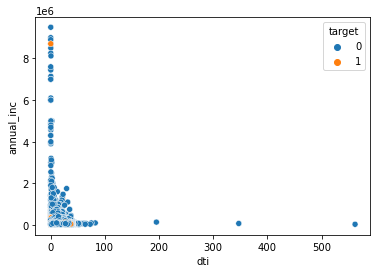

In [151]:
sns.scatterplot(data=X,x='dti',y='annual_inc',hue='target')
plt.show()

In [152]:
#Still a few outliers. Lets see if they are more realistic
X[X.dti>100][['annual_inc','tot_cur_bal','dti']]

,annual_inc,tot_cur_bal,dti
475046,31960.5,192764.0,561.765
532701,137500.0,314343.0,195.115
540456,71200.0,21380.0,347.120


In [153]:
#These still look suspicious so we wil remove those as well.
X=X[X.dti<=100]

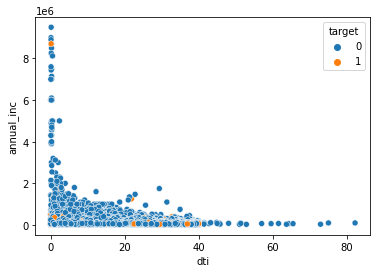

In [154]:
sns.scatterplot(data=X,x='dti',y='annual_inc',hue='target')
plt.show()

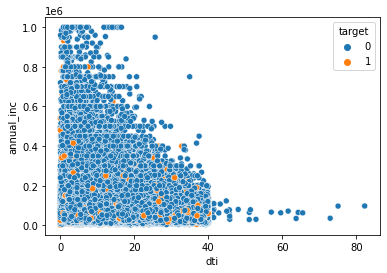

In [155]:
# we don't want to remove high income from the actual data set but we might get a better picture at looking at people with income under $1M
sns.scatterplot(data=X[X.annual_inc<=1000000],x='dti',y='annual_inc',hue='target')
plt.show()

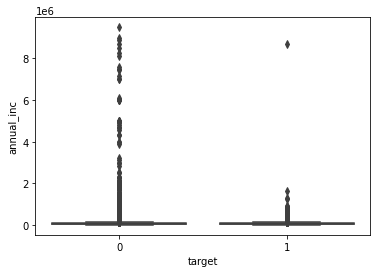

In [156]:
# We can look at some boxplots to see if we can see noticeable difference in the distributions of some features between positive and negative classes
sns.boxplot(data=X, x='target',y='annual_inc')
plt.show()

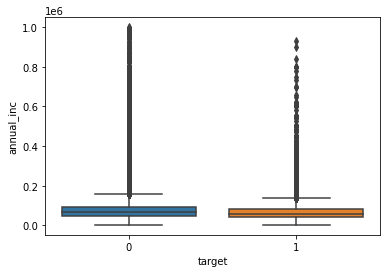

In [157]:
#outliers in income really make this hard to see, so we'll again limit to income under $1M
sns.boxplot(data=X[X.annual_inc<1000000], x='target',y='annual_inc')
plt.show()

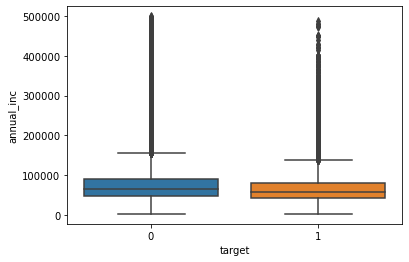

In [158]:
#hard to see a difference but again we have outliers. Let's limit this to income under 500000. We can look at the other group also
sns.boxplot(data=X[X.annual_inc<500000], x='target',y='annual_inc')
plt.show()

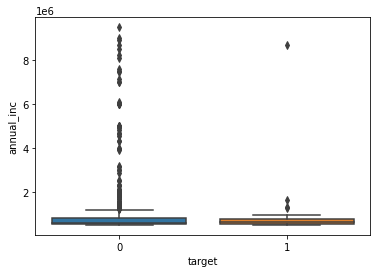

In [159]:
sns.boxplot(data=X[X.annual_inc>=500000], x='target',y='annual_inc')
plt.show()

In [160]:
#The images are a little hard to see, but initially looks like the distribution isn't significantly different.
X[X.target==1].annual_inc.describe()

count    5.881900e+04
mean     6.615066e+04
std      5.520877e+04
min      2.000000e+03
25%      4.100000e+04
50%      5.700000e+04
75%      8.000000e+04
max      8.706582e+06
Name: annual_inc, dtype: float64

In [161]:
X[X.target==0].annual_inc.describe()

count    8.285550e+05
mean     7.567356e+04
std      6.527481e+04
min      1.896000e+03
25%      4.600000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64

We can see a slight difference. The positive class overall had a slightly lower income (median 57000 vs median 65000, mean 66150.66 vs mean 75673.56)
We can look at DTI next

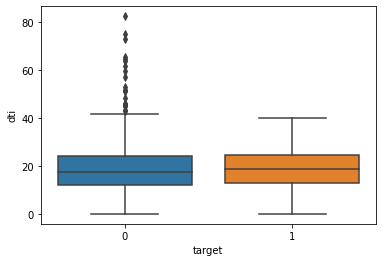

In [162]:
sns.boxplot(data=X, x='target',y='dti')
plt.show()

Negative class had lots of outliers (somewhat expected since it's a much larger group), but it looks like positive class tended towards slightly higher DTI
We can look in a little detail

In [163]:
X[X.target==0].dti.describe()

count    828555.000000
mean         18.091840
std           8.315711
min           0.000000
25%          11.850000
50%          17.590000
75%          23.900000
max          82.255000
Name: dti, dtype: float64

In [164]:
X[X.target==1].dti.describe()

count    58819.000000
mean        18.657158
std          8.076320
min          0.000000
25%         12.720000
50%         18.550000
75%         24.420000
max         39.990000
Name: dti, dtype: float64

There doesn't really appear to be a significant difference in the distribution between the two

In [165]:
X.grade.value_counts()

B    254535
C    245859
A    148202
D    139539
E     70704
F     23046
G      5489
Name: grade, dtype: int64

In [166]:
X2.grade.value_counts()

C    244903
B    230807
A    124517
D     97958
E     41254
F     14362
G      5537
Name: grade, dtype: int64

In [167]:
#Before trying to look at how grade is related, it will be useful to turn this into a numeric scale with 'G' at the bottom, 'A' at the top
grade_dict=dict({'G':0,'F':1,'E':2,'D':3,'C':4,'B':5,'A':6})
X['numeric_grade']=X.grade.map(grade_dict)
X2['numeric_grade']=X2.grade.map(grade_dict)

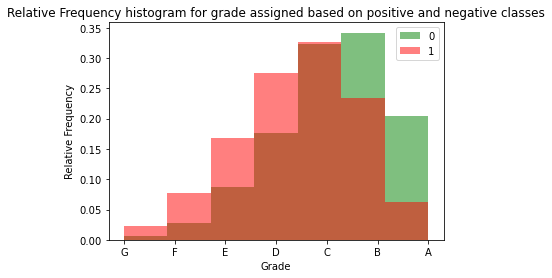

In [168]:
plt.hist(X[X.target==0].numeric_grade,alpha=0.5,color="green",bins=7,density=True)
plt.hist(X[X.target==1].numeric_grade,alpha=0.5,color="red",bins=7,density=True)
plt.legend(X.target)
plt.xlabel("Grade")
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=['G','F','E','D','C','B','A'])
plt.ylabel("Relative Frequency")
plt.title("Relative Frequency histogram for grade assigned based on positive and negative classes")
plt.show()

In [169]:
#We can see that the distribution here is different. #lets look at the summary statistics for grade separated
X[X.target==0].numeric_grade.describe()

count    828555.000000
mean          4.250722
std           1.294135
min           0.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           6.000000
Name: numeric_grade, dtype: float64

In [170]:
X[X.target==1].numeric_grade.describe()

count    58819.000000
mean         3.509699
std          1.374125
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          6.000000
Name: numeric_grade, dtype: float64

The median and quartiles are the same, but we can see that the mean for negative class is above a C, while the positive class is between a D and a C.

In [171]:
X.grade.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

We want to refine the grade using the subgrade information. So we can check to see that the letter grade in grade corresponds to the first character in the subgrade

In [172]:
X_graded=[]
for i in range(7):
    X_graded.append(X[X.numeric_grade==i])

In [173]:
X_graded[0].sub_grade.value_counts()

G1    1871
G2    1398
G3     981
G4     663
G5     576
Name: sub_grade, dtype: int64

In [174]:
X_graded[1].sub_grade.value_counts()

F1    7218
F2    5392
F3    4433
F4    3409
F5    2594
Name: sub_grade, dtype: int64

In [175]:
X_graded[6].sub_grade.value_counts()

A5    44816
A4    34531
A3    23457
A1    22913
A2    22485
Name: sub_grade, dtype: int64

In [176]:
X_graded[2].sub_grade.value_counts()

E1    18268
E2    17004
E3    14134
E4    11723
E5     9575
Name: sub_grade, dtype: int64

In [177]:
X_graded[3].sub_grade.value_counts()

D1    36238
D2    29803
D3    26552
D4    25558
D5    21388
Name: sub_grade, dtype: int64

In [178]:
X_graded[4].sub_grade.value_counts()

C1    53387
C2    52235
C3    50161
C4    48857
C5    41219
Name: sub_grade, dtype: int64

In [179]:
X_graded[5].sub_grade.value_counts()

B3    56323
B4    55626
B5    48833
B2    48781
B1    44972
Name: sub_grade, dtype: int64

In [180]:
#Lets see what the possible second values in the subgrade are
X.sub_grade.str.replace("[ABCDEFG]","",regex=True).astype(int).value_counts()

1    184867
4    180367
2    177098
3    176041
5    169001
Name: sub_grade, dtype: int64

To get a finer grade we will have to multiply the numeric grade by 5 (there are 5 possible subgrades). Assuming that the subgrades rank X1, X2,..X5 for each grade, we add 5-the subgrade to that.

In [181]:
X['fine_grade']=X.numeric_grade*5+(5-X.sub_grade.str.replace("[ABCDEFG]","",regex=True).astype(int))

In [182]:
X2['fine_grade']=X2.numeric_grade*5+(5-X2.sub_grade.str.replace("[ABCDEFG]","",regex=True).astype(int))

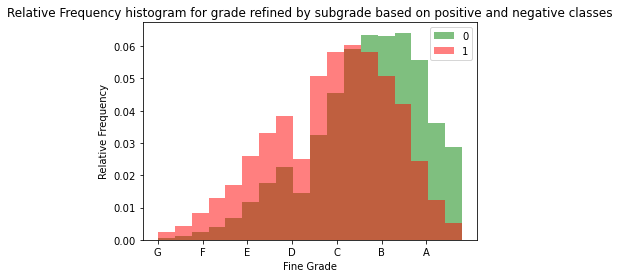

In [183]:
plt.hist(X[X.target==0].fine_grade,alpha=0.5,color="green",bins=18,density=True)
plt.hist(X[X.target==1].fine_grade,alpha=0.5,color="red",bins=18,density=True)
plt.legend(X.target)
plt.title ("Relative Frequency histogram for grade refined by subgrade based on positive and negative classes")
plt.xlabel("Fine Grade")
plt.xticks(ticks=[0,5,10,15,20,25,30],labels=['G','F','E','D','C','B','A'])
plt.ylabel("Relative Frequency")
plt.show()

Using the fine grade we can see a shift from the positive the negative classes.  Both are left tailed but the positive classes (bad loans) have a worse distribution of grades. Let's look at the boxplots

In [ ]:
sns.boxplot(data=X,y="fine_grade",x="target")
plt.title("Boxplots for refined grade for positive and negative classes")
plt.show()

In [185]:
#Summary statistics for the fine grade for the negative class
X[X.target==0].fine_grade.describe()

count    828555.000000
mean         23.288983
std           6.400977
min           0.000000
25%          19.000000
50%          24.000000
75%          28.000000
max          34.000000
Name: fine_grade, dtype: float64

In [186]:
#Summary statistics for the fine grade for the positive class
X[X.target==1].fine_grade.describe()

count    58819.000000
mean        19.534130
std          6.761077
min          0.000000
25%         15.000000
50%         20.000000
75%         25.000000
max         34.000000
Name: fine_grade, dtype: float64

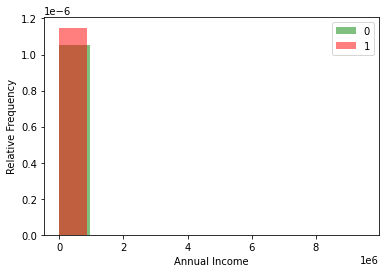

In [187]:
#Going back to income we can do frequency histograms for the positive and negative class to try to visualize if there's really a difference
plt.hist(X[X.target==0].annual_inc,alpha=0.5,color="green",bins=10,density=True)
plt.hist(X[X.target==1].annual_inc,alpha=0.5,color="red",bins=10,density=True)
plt.legend(X.target)
plt.xlabel("Annual Income")
plt.ylabel("Relative Frequency")
plt.show()

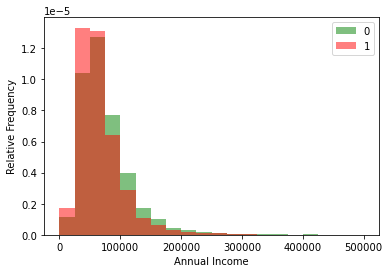

In [188]:
#outliers are a problem here. Just to get an idea we can look at income under 500k
plt.hist(X[X.target==0].annual_inc,alpha=0.5,color="green",bins=20,density=True,range=(0,500000))
plt.hist(X[X.target==1].annual_inc,alpha=0.5,color="red",bins=20,density=True,range=(0,500000))
plt.legend(X.target)
plt.xlabel("Annual Income")
plt.ylabel("Relative Frequency")
plt.show()

This visual seems to confirm what we saw before, but does show more values in the lower income ranges for bad loans compared to good loans.

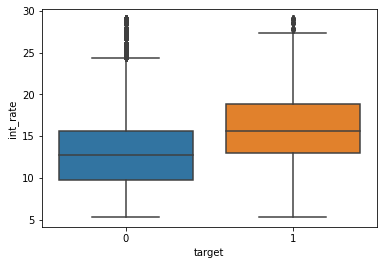

In [189]:
sns.boxplot(data=X, x='target',y='int_rate')
plt.show()

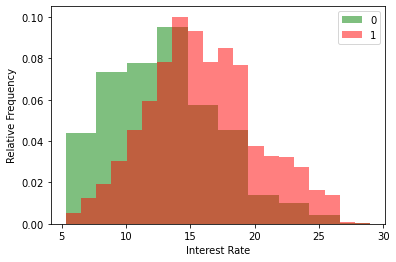

In [190]:
plt.hist(X[X.target==0].int_rate,alpha=0.5,color="green",bins=10,density=True)
plt.hist(X[X.target==1].int_rate,alpha=0.5,color="red",bins=20,density=True)
plt.legend(X.target)
plt.xlabel("Interest Rate")
plt.ylabel("Relative Frequency")
plt.show()

We can see that interest rates skewed more to the left for loans that were good. The only danger with using this is that presumably interest rates were higher for loan applicants thought to be higher risk, so it can be a circular predictor. It could also mean that higher interest rate loans were harder to pay back. It's worth looking at how interest rates were for different grades.

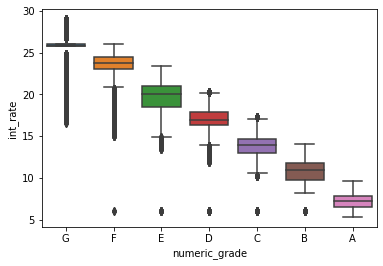

In [191]:
sns.boxplot(data=X,x="numeric_grade",y="int_rate")
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=['G','F','E','D','C','B','A'])
plt.show()

There is an obvious relation here that better grades resulted in a lower interest rate. 

In [192]:
#We can try to see how the grade and subgrade combined affected the mean interest rates.
ave_int=X.groupby("fine_grade").int_rate.mean()

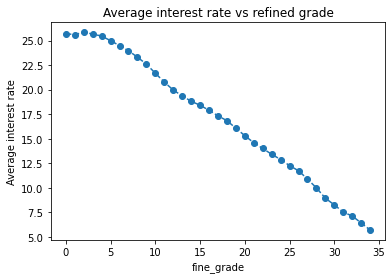

In [193]:
ave_int.plot(marker='o',linestyle='--')
plt.ylabel("Average interest rate")
plt.title("Average interest rate vs refined grade")
plt.show()

This correlation is so strong that it could be dangerous to use the grade/subgrade combined and the interest rate. 

In [194]:
ave_targets=X.groupby("fine_grade").target.mean()

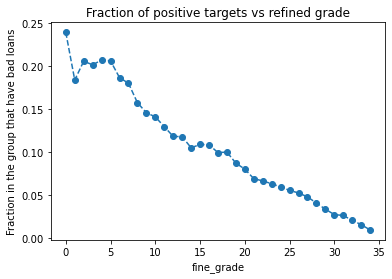

In [195]:
ave_targets.plot(marker='o',linestyle='--')
plt.ylabel("Fraction in the group that have bad loans")
plt.title("Fraction of positive targets vs refined grade")
plt.show()

We can see here a very similar graph to what we had before. It's a strong correlation from fine grade to probability of being a bad loan

In [196]:
X[X.sub_grade=="C2"].fine_grade

26        23
67        23
81        23
126       23
142       23
          ..
887312    23
887315    23
887323    23
887329    23
887344    23
Name: fine_grade, Length: 52235, dtype: int64

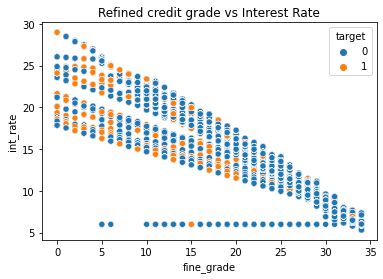

In [197]:
sns.scatterplot(data=X,x="fine_grade",y="int_rate",hue="target")
plt.title("Refined credit grade vs Interest Rate")
plt.show()

In [198]:
X.delinq_2yrs.value_counts()

0.0     716987
1.0     113224
2.0      33549
3.0      11977
4.0       5327
5.0       2711
6.0       1471
7.0        784
8.0        461
9.0        284
10.0       192
11.0       121
12.0        89
13.0        64
14.0        45
15.0        28
16.0        17
18.0        11
17.0        10
19.0         8
22.0         3
21.0         2
26.0         2
20.0         2
29.0         1
24.0         1
30.0         1
27.0         1
39.0         1
Name: delinq_2yrs, dtype: int64

In [199]:
delinq=X.groupby("delinq_2yrs").target.mean()

In [200]:
delinq.head()

delinq_2yrs
0.0    0.066916
1.0    0.063237
2.0    0.065069
3.0    0.066628
4.0    0.059508
Name: target, dtype: float64

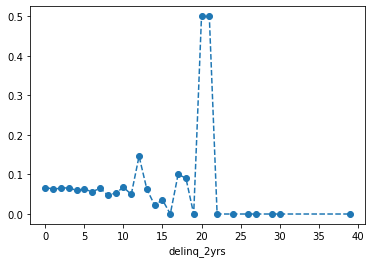

In [201]:
delinq.plot(marker="o",linestyle="--")
plt.show()

We can see a spike in the delinquencies in two years for the percentage of positive cases around 20 times.

In [202]:
X.revol_bal.value_counts()

0.0         3402
5235.0        74
5466.0        72
4479.0        68
8696.0        67
            ... 
63825.0        1
50651.0        1
143395.0       1
71192.0        1
75645.0        1
Name: revol_bal, Length: 73740, dtype: int64

In [203]:
X.revol_bal.unique()

array([13648.,  1687.,  2956., ..., 57516., 55667., 75645.])

In [204]:
len(X.revol_bal.unique())

73740

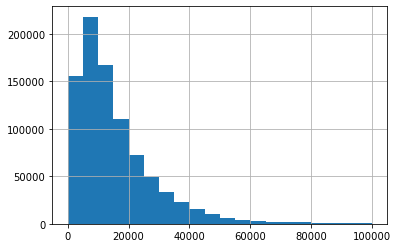

In [205]:
X.revol_bal.hist(bins=20,range=(0,100000))
plt.show()

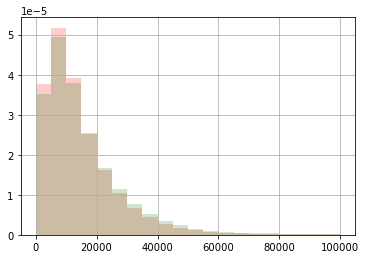

In [206]:
X[X.target==1].revol_bal.hist(bins=20,range=(0,100000),color="r",alpha=0.2,density=True)
X[X.target==0].revol_bal.hist(bins=20,range=(0,100000),color="g",alpha=0.2,density=True)
plt.show()

We can see that the distribution of revolving balances by frequency is very similar for both positive and negative classes

In [207]:
X.recoveries.describe()

count    887374.000000
mean         45.919502
std         409.695013
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       33520.270000
Name: recoveries, dtype: float64

In [208]:
X[X.recoveries==0].target.sum()/len(X[X.recoveries==0])

0.03957588817394751

In [209]:
X[X.recoveries>0].target.sum()/len(X[X.recoveries>0])

1.0

In [210]:
X[X.recoveries>0].target.mean()

1.0

In [211]:
len(X[X.recoveries>0])

24677

In [212]:
len(X[(X.recoveries>0) & (X.target==0)])

0

We definitely found one strong indicator. Anyone who had post charge off recovery more than 0 was bad. It's worth looking to see what actual values we had

In [213]:
X.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'last_credit_pull_d', 'last_pymnt_d',
       'earliest_cr_line', 'next_pymnt_d', 'target', 'missing_columns',

In [214]:
df.shape

(887379, 74)

In [215]:
X.shape

(887374, 56)

In [216]:
ls=df[df.dti<=100].loan_status

In [217]:
ls[X.recoveries>0].value_counts()

Charged Off                                            24187
Does not meet the credit policy. Status:Charged Off      490
Name: loan_status, dtype: int64

It appears that the recoveries column relates to the Lending Club loan as anyone who had a recovery had a status of a loan being charged off. 

In [218]:
X[X.collection_recovery_fee>0].target.mean()

1.0

In [219]:
ls[X.collection_recovery_fee>0].value_counts()

Charged Off                                            23035
Does not meet the credit policy. Status:Charged Off      472
Name: loan_status, dtype: int64

In [220]:
X.collections_12_mths_ex_med.describe()

count    887374.000000
mean          0.014377
std           0.134180
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: collections_12_mths_ex_med, dtype: float64

In [221]:
X[X.collections_12_mths_ex_med>0].target.mean()

0.04819792825956682

In [222]:
X[X.collections_12_mths_ex_med==0].target.mean()

0.06652559744111235

The refined grade score seemed like a relevant feature. We want to compute weight of evidence and information value for this feature

In [223]:


#Method to get WoE for the feature
def WoE(X,feature,target,adjust=0,bins=10):
    #We will assume here that the target column is binary 0 or 1 and 1 is "bad"
    #create the bins
    bin_series=pd.cut(X[feature],bins=bins)
    #find the number of bad in each
    num_of_bad_by_bins=X.groupby(bin_series)[target].sum()
    #find number of entries in each
    num_of_entries_in_bin=X.groupby(bin_series)[target].count()
    #find number of good in each
    num_of_good_by_bins=num_of_entries_in_bin-num_of_bad_by_bins
    #Get distributions
    dist_of_bad_by_bins=num_of_bad_by_bins/num_of_bad_by_bins.sum()
    dist_of_good_by_bins=num_of_good_by_bins/num_of_good_by_bins.sum()
    WoE=np.log((dist_of_good_by_bins+adjust)/(dist_of_bad_by_bins+adjust))
    return WoE

#Method to return the IV(Information value) for a dataframe for a particular feature to a binary target
def IV(X,feature,target,adjust=0,bins=10):  # adjust is a value to get an adjusted WoE if we have bins with no good or no bad values
    #create the bins
    bin_series=pd.cut(X[feature],bins=bins)
    #find the number of bad in each
    num_of_bad_by_bins=X.groupby(bin_series)[target].sum()
    #find number of entries in each
    num_of_entries_in_bin=X.groupby(bin_series)[target].count()
    #find number of good in each
    num_of_good_by_bins=num_of_entries_in_bin-num_of_bad_by_bins
    #Get distributions
    dist_of_bad_by_bins=num_of_bad_by_bins/num_of_bad_by_bins.sum()
    dist_of_good_by_bins=num_of_good_by_bins/num_of_good_by_bins.sum()
    IV=WoE(X,feature,target,adjust,bins)*(dist_of_good_by_bins-dist_of_bad_by_bins)
   

    return IV


In [224]:
fine_gradeIV=IV(X,"fine_grade","target",0,17)
fine_gradeIV.sum()

0.34721400559284754

An IV of .3472 seems like this is a very significant feature

In [225]:
WoE(X,"fine_grade","target",0,17)

fine_grade
(-0.034, 2.0]   -1.308851
(2.0, 4.0]      -1.289614
(4.0, 6.0]      -1.228876
(6.0, 8.0]      -1.044184
(8.0, 10.0]     -0.855888
(10.0, 12.0]    -0.685044
(12.0, 14.0]    -0.567753
(14.0, 16.0]    -0.541562
(16.0, 18.0]    -0.445329
(18.0, 20.0]    -0.248885
(20.0, 22.0]    -0.023527
(22.0, 24.0]     0.083601
(24.0, 26.0]     0.221566
(26.0, 28.0]     0.421556
(28.0, 30.0]     0.818567
(30.0, 32.0]     1.066624
(32.0, 34.0]     1.734047
Name: target, dtype: float64

In [226]:
WoE(X,"int_rate","target",0,20)

int_rate
(5.296, 6.504]      2.041698
(6.504, 7.687]      1.341069
(7.687, 8.87]       1.316451
(8.87, 10.054]      0.909645
(10.054, 11.238]    0.381557
(11.238, 12.421]    0.401709
(12.421, 13.604]    0.207823
(13.604, 14.788]   -0.060201
(14.788, 15.972]   -0.416708
(15.972, 17.155]   -0.373142
(17.155, 18.338]   -0.465005
(18.338, 19.522]   -0.726858
(19.522, 20.706]   -0.845252
(20.706, 21.889]   -0.999687
(21.889, 23.072]   -1.004509
(23.072, 24.256]   -1.247536
(24.256, 25.44]    -1.200974
(25.44, 26.623]    -1.235618
(26.623, 27.806]    0.160774
(27.806, 28.99]     0.094509
Name: target, dtype: float64

In [229]:
X_has_derog=X[X.mths_since_last_major_derog<10000]

In [230]:
X_has_derog[X_has_derog.target==0].mths_since_last_major_derog.describe()

count    209250.000000
mean         44.178858
std          22.183143
min           0.000000
25%          27.000000
50%          44.000000
75%          61.000000
max         188.000000
Name: mths_since_last_major_derog, dtype: float64

In [231]:
X_has_derog[X_has_derog.target==1].mths_since_last_major_derog.describe()

count    12450.000000
mean        42.861446
std         22.086885
min          0.000000
25%         25.000000
50%         42.000000
75%         60.000000
max        152.000000
Name: mths_since_last_major_derog, dtype: float64

In [232]:
info=IV(X_has_derog,"mths_since_last_major_derog","target",0.1,10)

In [233]:
print(info)

mths_since_last_major_derog
(-0.188, 18.8]    1.527684e-03
(18.8, 37.6]      2.709927e-05
(37.6, 56.4]      1.106030e-07
(56.4, 75.2]      1.253471e-03
(75.2, 94.0]      1.049531e-05
(94.0, 112.8]     3.576342e-05
(112.8, 131.6]    1.260325e-05
(131.6, 150.4]    2.992075e-06
(150.4, 169.2]    3.391555e-08
(169.2, 188.0]    1.118903e-08
Name: target, dtype: float64


In [234]:
info.sum()

0.00287026404065677

In [235]:
WoE(X_has_derog,"mths_since_last_major_derog","target",0.1,10)

mths_since_last_major_derog
(-0.188, 18.8]   -0.077344
(18.8, 37.6]     -0.008674
(37.6, 56.4]     -0.000542
(56.4, 75.2]      0.060680
(75.2, 94.0]     -0.008136
(94.0, 112.8]     0.018493
(112.8, 131.6]    0.011080
(131.6, 150.4]    0.005439
(150.4, 169.2]    0.000582
(169.2, 188.0]    0.000334
Name: target, dtype: float64

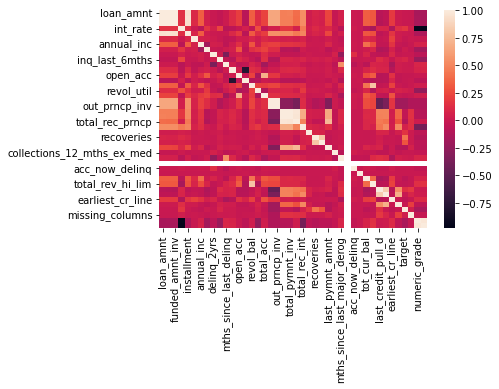

In [236]:
sns.heatmap(X.corr())
plt.show()

In [237]:
X.tot_coll_amt.value_counts()

0.0       771217
50.0        1755
100.0       1357
75.0        1044
200.0        714
           ...  
4891.0         1
7184.0         1
4242.0         1
9477.0         1
8567.0         1
Name: tot_coll_amt, Length: 10325, dtype: int64

In [238]:
X[X.tot_coll_amt>0].target.mean()

0.0531521991786978

In [239]:
X[X.tot_coll_amt==0].target.mean()

0.06826224006991548

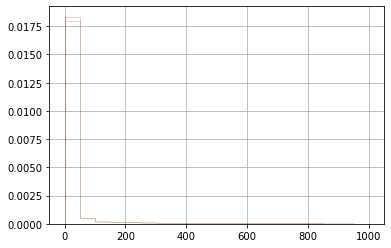

In [240]:
X[X.target==0].tot_coll_amt.hist(color="g",alpha=0.2,density=True,range=(0,1000),histtype="step",bins=20)
X[X.target==1].tot_coll_amt.hist(color="r",alpha=0.2,density=True,range=(0,1000),histtype="step",bins=20)
plt.show()

In [241]:
X[(X.target==0) & (X.tot_coll_amt<100000)].tot_coll_amt.max()

99950.0

In [242]:
X[X.target==1].tot_coll_amt.max()

95806.0

In [243]:
X[X.target==0].tot_coll_amt.describe()

count    8.285550e+05
mean     2.135225e+02
std      1.023403e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64

In [244]:
X[X.target==1].tot_coll_amt.describe()

count    58819.000000
mean       127.630936
std       1315.330674
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      95806.000000
Name: tot_coll_amt, dtype: float64

Total collection amount doesn't look great for a feature for prediction. We can keep it and if we have trouble getting a good model ,remove it and retrain

In [245]:
X.dtypes

loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                     float64
home_ownership                  object
annual_inc                     float64
verification_status             object
pymnt_plan                      object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                

In [246]:
X.dtypes[X.dtypes=="object"]

term                         object
grade                        object
sub_grade                    object
emp_title                    object
home_ownership               object
verification_status          object
pymnt_plan                   object
purpose                      object
title                        object
zip_code                     object
addr_state                   object
initial_list_status          object
application_type             object
verification_status_joint    object
dtype: object

Before modeling we need to look at each of these and see how to deal with each

In [247]:
X.term.value_counts()

 36 months    621121
 60 months    266253
Name: term, dtype: int64

In [248]:
X.term=X.term.map({" 36 months":36," 60 months":60})

In [249]:
X.term.value_counts()

36    621121
60    266253
Name: term, dtype: int64

In [250]:
X2.term=X2.term.map({"36 months":36,"60 months":60})

In [251]:
#We have numeric versions of the grade and sub_grade so we can get rid of the strings
X.drop(columns=["grade","sub_grade"],inplace=True)
X2.drop(columns=["grade","sub_grade"],inplace=True)

In [252]:
X.emp_title.unique()

array(['other', 'Ryder', 'AIR RESOURCES BOARD', ...,
       'machining Cell Lead', 'KYC Business Analyst',
       'Manager Hotel Operations Oasis '], dtype=object)

In [253]:
len(X.emp_title.unique())

299270

We have 299270 different titles. That would create a huge number of features if we just one hot encode this.

In [254]:
type(X.emp_title.value_counts())

pandas.core.series.Series

In [255]:
X.emp_title.value_counts()[X.emp_title.value_counts()>1]

other                       51459
Teacher                     13469
Manager                     11240
Registered Nurse             5525
Owner                        5376
                            ...  
Redwood Credit Union            2
Administrative Aide             2
Lead Datacenter Engineer        2
enviromental services           2
Phoenix American                2
Name: emp_title, Length: 53685, dtype: int64

In [256]:
X.emp_title.value_counts()[X.emp_title.value_counts()>1000]

other                       51459
Teacher                     13469
Manager                     11240
Registered Nurse             5525
Owner                        5376
RN                           5355
Supervisor                   4983
Sales                        4212
Project Manager              3988
Driver                       3569
Office Manager               3510
General Manager              3178
Director                     3156
manager                      3138
teacher                      2925
owner                        2849
Engineer                     2671
President                    2598
driver                       2429
Vice President               2351
Attorney                     2136
Operations Manager           2071
Accountant                   2035
Administrative Assistant     2019
Sales Manager                1846
Account Manager              1725
sales                        1724
Police Officer               1720
supervisor                   1675
Executive Assi

In [257]:
engineer_titles=[]
for st in X.emp_title.unique():
    if "engineer" in str.lower(st):
        engineer_titles.append(st)

In [258]:
manager_titles=[]
for st in X.emp_title.unique():
    if "manager" in str.lower(st):
        manager_titles.append(st)

In [259]:
len(engineer_titles)

5881

In [260]:
len(manager_titles)

21136

In [261]:
education_titles=[]
for st in X.emp_title.unique():
    if ("teach" in str.lower(st)) or ("professor" in str.lower(st)) or ("educ" in str.lower(st)):
        education_titles.append(st)

In [262]:
len(education_titles)

3379

In [263]:
education_titles[:10]

['bmg-educational',
 'Global Teachers Research and Resources',
 'S&V Education Systems/ Middle GA Center',
 'West Metro Education Partners',
 'Knott County Board of Education',
 'US Department of Education',
 'Imperial County Office of Education',
 'Follett Higher Education Group',
 'North Bergen Board of Education',
 'Educational Testing Service']

In [264]:
X.home_ownership.value_counts()

MORTGAGE    443553
RENT        356116
OWN          87470
OTHER          182
NONE            50
ANY              3
Name: home_ownership, dtype: int64

In [265]:
X2.home_ownership.value_counts()

MORTGAGE    371579
RENT        297100
OWN          90151
ANY            504
NONE             4
Name: home_ownership, dtype: int64

Home ownership only has a few possible values. One-hot encoding should work fine here

In [266]:
X.pymnt_plan.value_counts()

n    887364
y        10
Name: pymnt_plan, dtype: int64

In [267]:
X2.pymnt_plan.value_counts()

n    758794
y       544
Name: pymnt_plan, dtype: int64

There aren't many "y" values in each, but we can simply map n to 0 and y to 1 to get a binary feature.

In [268]:
X.pymnt_plan=X.pymnt_plan.map({"n":0,"y":1})
X2.pymnt_plan=X2.pymnt_plan.map({"n":0,"y":1})

In [269]:
X.purpose.value_counts()

debt_consolidation    524213
credit_card           206180
home_improvement       51829
other                  42893
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

In [270]:
X2.purpose.value_counts()

debt_consolidation    431530
credit_card           157768
home_improvement       57197
other                  50680
major_purchase         18319
medical                10360
car                     8777
small_business          8235
vacation                6416
moving                  5973
house                   3561
renewable_energy         519
wedding                    3
Name: purpose, dtype: int64

We have a relatively small number of values here, so we can one-hot encode these later

In [271]:
X.title.value_counts()

Debt consolidation                     413999
Credit card refinancing                164329
Home improvement                        40112
Other                                   31891
Debt Consolidation                      15760
                                        ...  
New Heater                                  1
Looking to get out of debt                  1
Debt Conso/Pay off initial LC loan          1
Emergency Home Repair                       1
Credit Card/Auto Repair                     1
Name: title, Length: 63144, dtype: int64

In [272]:
X2.title.value_counts().index

Index(['Debt consolidation', 'Credit card refinancing', 'Home improvement',
       'Other', 'other', 'Major purchase', 'Medical expenses', 'Car financing',
       'Business', 'Vacation', 'Moving and relocation', 'Home buying',
       'Green loan', 'Credit Card Consolidation'],
      dtype='object')

In [273]:
X.title.value_counts()[X.title.value_counts()>1]

Debt consolidation         413999
Credit card refinancing    164329
Home improvement            40112
Other                       31891
Debt Consolidation          15760
                            ...  
Motorcycle Financing            2
September 2011 Loan             2
Debt Free 2011                  2
Medical Debt Relief             2
Best Buy                        2
Name: title, Length: 9178, dtype: int64

We have a lot of purposes listed, many of which only occur once. We can possibly call those "other" or try something else. 

In [274]:
X.zip_code.value_counts()

945xx    9770
750xx    9417
112xx    9272
606xx    8641
300xx    8126
         ... 
569xx       1
348xx       1
819xx       1
375xx       1
507xx       1
Name: zip_code, Length: 935, dtype: int64

In [275]:
X.addr_state.value_counts()

CA    129517
NY     74086
TX     71133
FL     60935
IL     35476
NJ     33256
PA     31393
OH     29631
GA     29085
VA     26255
NC     24720
MI     22985
MD     21031
MA     20593
AZ     20412
WA     19434
CO     18807
MN     15957
MO     14207
IN     13789
CT     13531
TN     12887
NV     12443
WI     11574
AL     11200
OR     10893
SC     10639
LA     10587
KY      8550
OK      8085
KS      7926
AR      6640
UT      6264
NM      4939
HI      4570
WV      4386
NH      4294
RI      3893
MS      3819
MT      2558
DE      2511
DC      2432
AK      2205
WY      2028
SD      1815
VT      1797
NE      1176
ME       525
ND       479
IA        14
ID        12
Name: addr_state, dtype: int64

We could one-hot encode these. However, the zip code is a refined location tag , so it might make sense to simply drop this and use the location based on zip code.

In [276]:
X.title.value_counts()

Debt consolidation                     413999
Credit card refinancing                164329
Home improvement                        40112
Other                                   31891
Debt Consolidation                      15760
                                        ...  
New Heater                                  1
Looking to get out of debt                  1
Debt Conso/Pay off initial LC loan          1
Emergency Home Repair                       1
Credit Card/Auto Repair                     1
Name: title, Length: 63144, dtype: int64

In [277]:
X.purpose.value_counts()

debt_consolidation    524213
credit_card           206180
home_improvement       51829
other                  42893
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

"Purpose" and "title" seem to have similar types of values, but "purpose" has fewer values.

In [278]:
set(X.purpose.unique()).difference(set(X2.purpose.unique()))

{'educational'}

In [279]:
set(X2.purpose.unique()).difference(set(X.purpose.unique()))

set()

The other advanatage of purpose is that we aren't as likely to get a new purpose shown. With "title" we'd really need to have some kind of metric or clustering associated that we could apply to a new loan.

In [280]:
X.initial_list_status.value_counts()

f    456846
w    430528
Name: initial_list_status, dtype: int64

In [281]:
X2.initial_list_status.value_counts()

w    580878
f    178460
Name: initial_list_status, dtype: int64

Initial list status is a binary feature so we can simply convert to 0 and 1


In [282]:
X.initial_list_status=X.initial_list_status.map({"f":0,"w":1})
X2.initial_list_status=X2.initial_list_status.map({"f":0,"w":1})

In [283]:
X.verification_status.value_counts()

Source Verified    329557
Verified           291070
Not Verified       266747
Name: verification_status, dtype: int64

In [284]:
X.verification_status_joint.value_counts()

Source Verified    329484
Verified           290976
Not Verified       266914
Name: verification_status_joint, dtype: int64

In [285]:
X[X.verification_status_joint!=X.verification_status].verification_status_joint.value_counts()

Not Verified       167
Source Verified     22
Name: verification_status_joint, dtype: int64

In [286]:
X[(X.verification_status_joint!=X.verification_status) & (X.verification_status_joint=="Not Verified")].verification_status.value_counts()

Source Verified    95
Verified           72
Name: verification_status, dtype: int64

In [287]:
X[(X.verification_status_joint!=X.verification_status) & (X.verification_status_joint=="Source Verified")].verification_status.value_counts()

Verified    22
Name: verification_status, dtype: int64

We have some possible ways to deal with different verification on a joint loan. One possibility is essentially to say that if one was verified, treat it as verified, if neither were verified, but one was source verified, treat it as source verified, and if both were not verified treat it as not verified.

At this point we have a few things to finalize before being able to attempt a model

1)How to treat the employment title. One hot encoding can't work because we might get a new employment title entered. We might try some kind of clustering to get only a few types of possible employment. This would be some kind of clustering and/or labeling by title.

2)How to deal with "purpose" and "title" : "Purpose" seems to have fewer possible values. This helps with not having too many features if we choose to one-hot encode, and also avoids problems if a new title that wasn't on the list arises. To use we'd have to cluster/label by title. Also there seems to be a lot of overlap and "title" just includes some little used purposes.

3)How to deal with different levels of verification for income in a joint loan.

4)Minor, but we know we have some features that are strings that we will need to one-hot encode

In [288]:
X.purpose.value_counts()

debt_consolidation    524213
credit_card           206180
home_improvement       51829
other                  42893
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

In [289]:
X[X.purpose=="debt_consolidation"].title.value_counts()

Debt consolidation                        413226
Debt Consolidation                         14731
debt consolidation                          4572
Consolidation                               4559
Debt Consolidation Loan                     3667
                                           ...  
Catch up with bills                            1
drbt consolidation                             1
Working hard to get out of debt                1
Home imprvmnt and credit consolidation         1
Credit Card/Auto Repair                        1
Name: title, Length: 33265, dtype: int64

As an example we see that purpose of debt consolidation includes variations on capitalization, leaving out "debt", adding "loan", typos. It would probably be best to lump those together.

In [290]:
X[X.purpose=="credit_card"].title.value_counts()

Credit card refinancing         163952
Credit Card Refinance             1419
Credit Card Consolidation         1154
Credit Card Payoff                 889
Debt Consolidation                 810
                                 ...  
Consolidate at a Better Rate         1
Credit Colsolidatoin                 1
consulidation                        1
Consiladation                        1
Pay off Lowes Card                   1
Name: title, Length: 15160, dtype: int64

We can see a similar situation for "credit_card" purposes.

In [291]:
X[X.purpose=="home_improvement"].title.value_counts()

Home improvement                 39951
Home Improvement                  1530
home improvement                   574
Home Improvement Loan              550
Home                               174
                                 ...  
Home Improvement - Siding            1
Home Improvemnet                     1
Home Improvement/Debt Paydown        1
Sunshine                             1
new kitchen for momma!               1
Name: title, Length: 4996, dtype: int64

This pattern continues with variations for home improvement. This really suggests that we drop "title" and just use "purpose" to get a set of possible values for a feature rather than try to cluster the titles using some other model.

## Final Preprocessing

#### Clustering the employment titles

We want to get groups of "similar" employment titles so that we can then encode those without needing a huge number of features and so that we can deal with titles not already in the list

In [292]:
#import libraries to vectorize and cluster the employment titles
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [293]:
#Train a vectorizer on the employment titles
tdfv=TfidfVectorizer()
tf_model=tdfv.fit(X.emp_title)
X_emp_vecs=tf_model.transform(X.emp_title)

In [294]:
#Train a K Means model with 10 clusters on the vectorized titles
km_10=KMeans(n_clusters=10)
km_model=km_10.fit(X_emp_vecs)

In [295]:
km_model.labels_[:10]

array([7, 0, 7, 0, 0, 0, 0, 0, 7, 0])

Let's see how this labelling went

In [296]:
X["emp_labels"]=km_model.labels_

In [297]:
for i in range(10):
    print("Label ",i)
    print(X[X.emp_labels==i].emp_title.head())

Label  0
1                        Ryder
3          AIR RESOURCES BOARD
4     University Medical Group
5         Veolia Transportaton
6    Southern Star Photography
Name: emp_title, dtype: object
Label  1
17918    Consultant Engineering, Inc.
27724           Expert Consultant Inc
34806        Self Employed Consultant
35446                   IT Consultant
36048    Consultant Engineering, Inc.
Name: emp_title, dtype: object
Label  2
20538                 cellular sales
26016        C & B Sales and Service
35324    Advantage Sales & Marketing
37710    F&C Truck Sales and Service
42546             Area Sales Manager
Name: emp_title, dtype: object
Label  3
42543    Registered Nurse
42564          LPN  nurse
42598    Registered Nurse
42654    Registered Nurse
42655    Registered Nurse
Name: emp_title, dtype: object
Label  4
42537    MANAGER INFORMATION DELIVERY
42550                   PARTS MANAGER
42553                 Project Manager
42555              Operations Manager
42570              

It might not be ideal, but at least for a first attempt to build a model, it seems like something we can use.
We won't want the actual numbers to be used, because it's not ordinal data. We will have to use these labels to dummy encode.

#### Final preprocessing of both data sets

In [298]:
X.emp_labels

0         7
1         0
2         7
3         0
4         0
         ..
887374    0
887375    0
887376    0
887377    0
887378    0
Name: emp_labels, Length: 887374, dtype: int32

In [299]:
X.emp_labels="emp_label"+X.emp_labels.astype("str")

In [300]:
X.drop(columns=["emp_title","title","numeric_grade"],inplace=True)

In [301]:
X.dtypes

loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                             int64
int_rate                       float64
installment                    float64
emp_length                     float64
home_ownership                  object
annual_inc                     float64
verification_status             object
pymnt_plan                       int64
purpose                         object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util                     float64
total_acc                      float64
initial_list_status              int64
out_prncp                

In [302]:
X.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'last_credit_pull_d', 'last_pymnt_d',
       'earliest_cr_line', 'next_pymnt_d', 'target', 'missing_columns',
       'fine_grade', 'emp_labels'],
      d

In [303]:
#Now we need to do the same for the test data

#cluster the employment titles using the same method as for the training data
X2_emp_vecs=tf_model.transform(X2.emp_title)
X2_emp_labels=km_10.predict(X2_emp_vecs)

In [304]:
X2["emp_labels"]=X2_emp_labels

In [305]:
X2.emp_labels="emp_label"+X2.emp_labels.astype("str")

In [306]:
X2.drop(columns=["emp_title","title","numeric_grade"],inplace=True)

In [307]:
set(X.columns).difference(set(X2.columns))
    

set()

In [308]:
set(X2.columns).difference(set(X.columns))

set()

In [309]:
list(X.select_dtypes("object").columns)

['home_ownership',
 'verification_status',
 'purpose',
 'zip_code',
 'addr_state',
 'application_type',
 'verification_status_joint',
 'emp_labels']

In [310]:
list(X2.select_dtypes("object").columns)

['home_ownership',
 'verification_status',
 'purpose',
 'zip_code',
 'addr_state',
 'application_type',
 'verification_status_joint',
 'emp_labels']

Before dummy encoding the string features, we need to see if there are values for each that might not appear in one of the sets. 

In [311]:
for col in list(X.select_dtypes("object").columns):
    print ("Column : ",col)
    print ("In X, but not X2")
    print (set(X[col].values).difference(set(X2[col].values)))
    print ("In X2, but not X")
    print (set(X2[col].values).difference(set(X[col].values)))

Column :  home_ownership
In X, but not X2
{'OTHER'}
In X2, but not X
set()
Column :  verification_status
In X, but not X2
set()
In X2, but not X
set()
Column :  purpose
In X, but not X2
{'educational'}
In X2, but not X
set()
Column :  zip_code
In X, but not X2
{'375xx', '269xx', '501xx', '522xx', '929xx', '889xx', '643xx', '849xx', '819xx', '524xx', '429xx', '649xx', '520xx', '504xx', '817xx', '771xx', '938xx', '888xx', '862xx', '516xx', '507xx', '568xx', '399xx', '205xx', '511xx', '513xx', '892xx', '509xx', '527xx', '514xx', '503xx', '682xx'}
In X2, but not X
{'872xx', '515xx', '964xx', '009xx', '552xx', '966xx', '055xx', '885xx', '095xx', '345xx', '987xx', '202xx', '698xx', '696xx', '525xx', '521xx'}
Column :  addr_state
In X, but not X2
{'IA'}
In X2, but not X
set()
Column :  application_type
In X, but not X2
set()
In X2, but not X
set()
Column :  verification_status_joint
In X, but not X2
set()
In X2, but not X
set()
Column :  emp_labels
In X, but not X2
set()
In X2, but not X
set(

We can see a few things. The training data contains a home ownership of "other" which the test data does not. It also contains a purpose of "educational" which the test data does not. The zip codes definitely vary.

For the first two we have two options. 

1)We can stack the dataframes on top of each other (with a feature flag to tell us if it was from the training or test data) and dummy encode them together

2)We can simply add an additional column for the missing values once the test data has been dummy encoded. 

The former seems a bit easier and we can separate them after by using the flag variable introduced

The zip codes are slightly more complicated. There could easily be missing zip codes from both, so we can't simply combine to dummy encode the zip codes, because that still won't help with a new loan application that has a zip code that isn't in either.

We can look at the following possible solutions:

1)Drop the zip code entirely and use the state 

2)Get a numeric value based on the first 3 digits

3)Make sure the data includes dummy columns for all 1000 possible zip codes.

(1) is easy though it loses some granularity (lumping everyone in a state like CA or NY might lose some useful information)

(2) is easy to do. However treating it as numeric means that it becomes ordinal when a model uses it and it's not necessarily best. There are geographic relationships that might actually be relevant 

(3) Can be done but creates 1000 features that will be sparse. 

In [312]:
for code in sorted(X.zip_code.unique()):
    print (code)
    print( X[X.zip_code==code].addr_state.unique())

007xx
['NJ' 'PA' 'FL']
008xx
['VA']
010xx
['MA' 'CT']
011xx
['MA' 'CT']
012xx
['MA']
013xx
['MA']
014xx
['MA' 'KS']
015xx
['MA']
016xx
['MA' 'WA']
017xx
['MA' 'NY' 'MI' 'CA']
018xx
['MA' 'RI']
019xx
['MA' 'ME']
020xx
['MA' 'RI']
021xx
['MA' 'MD' 'NY' 'FL' 'ME' 'TX']
022xx
['MA']
023xx
['MA']
024xx
['MA']
025xx
['MA']
026xx
['MA' 'RI' 'PA' 'CA']
027xx
['MA' 'MD' 'RI']
028xx
['RI' 'VA' 'MA' 'PA']
029xx
['RI' 'MA']
030xx
['NH' 'NJ' 'MA']
031xx
['NH' 'CT']
032xx
['NH']
033xx
['NH' 'FL']
034xx
['NH' 'MA' 'CT']
035xx
['NH']
036xx
['NH']
037xx
['NH' 'NJ']
038xx
['NH']
039xx
['ME' 'RI']
040xx
['MA' 'ME']
041xx
['ME' 'NH']
042xx
['ME']
043xx
['MD' 'ME' 'CT' 'MA']
044xx
['MA' 'ME' 'NJ']
045xx
['ME' 'CA' 'NJ' 'VT']
046xx
['ME']
047xx
['ME']
048xx
['ME']
049xx
['NH' 'ME' 'MA']
050xx
['VT']
051xx
['VT']
052xx
['VT']
053xx
['VT' 'MA' 'NH']
054xx
['VT' 'NY']
056xx
['VT']
057xx
['VT' 'MA']
058xx
['VT']
059xx
['VT']
060xx
['CT' 'CO']
061xx
['CT' 'IL' 'NY' 'CO']
062xx
['CT' 'FL']
063xx
['CT' 'NY' 'CO']


We have some zipcodes being given with different states, which makes them somewhat suspect to use (For example the 990xx has states listed as Washington, California, Arkansas even though the 990xx zip codes are all in Washington. This tends to suggest to not use the zip codes, but just the states

In [313]:
X.addr_state.value_counts()

CA    129517
NY     74086
TX     71133
FL     60935
IL     35476
NJ     33256
PA     31393
OH     29631
GA     29085
VA     26255
NC     24720
MI     22985
MD     21031
MA     20593
AZ     20412
WA     19434
CO     18807
MN     15957
MO     14207
IN     13789
CT     13531
TN     12887
NV     12443
WI     11574
AL     11200
OR     10893
SC     10639
LA     10587
KY      8550
OK      8085
KS      7926
AR      6640
UT      6264
NM      4939
HI      4570
WV      4386
NH      4294
RI      3893
MS      3819
MT      2558
DE      2511
DC      2432
AK      2205
WY      2028
SD      1815
VT      1797
NE      1176
ME       525
ND       479
IA        14
ID        12
Name: addr_state, dtype: int64

In [314]:
len(X.addr_state.value_counts())

51

In [315]:
#For now we drop the zip codes because of the difficulty of how to best encode as well as the inconsistencies of what states they belong to
X.drop(columns=["zip_code"],inplace=True)
X2.drop(columns=["zip_code"],inplace=True)

In [316]:
X.select_dtypes("object").columns

Index(['home_ownership', 'verification_status', 'purpose', 'addr_state',
       'application_type', 'verification_status_joint', 'emp_labels'],
      dtype='object')

In [317]:
X2.select_dtypes("object").columns

Index(['home_ownership', 'verification_status', 'purpose', 'addr_state',
       'application_type', 'verification_status_joint', 'emp_labels'],
      dtype='object')

In [318]:
#Create a flag column for train / test data so we can stack them to dummy encode, then separate if needed later
X["train"]=1
X2["train"]=0

In [319]:
X.train.head()

0    1
1    1
2    1
3    1
4    1
Name: train, dtype: int64

In [320]:
X2.train.head()

0    0
1    0
2    0
3    0
4    0
Name: train, dtype: int64

In [321]:
X_combined=pd.concat([X,X2],axis=0)

In [322]:
X_combined.shape

(1646712, 52)

In [323]:
X_combined.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,total_rev_hi_lim,last_credit_pull_d,last_pymnt_d,earliest_cr_line,next_pymnt_d,target,missing_columns,fine_grade,emp_labels,train
0,5000.0,5000.0,4975.0,36,10.65,162.87,10.0,RENT,24000.0,Verified,...,23700.0,1492.0,1127.0,9830.0,306.0,0,13,28,emp_label7,1
1,2500.0,2500.0,2500.0,60,15.27,59.83,0.0,RENT,30000.0,Source Verified,...,23700.0,640.0,487.0,4627.0,306.0,1,13,21,emp_label0,1
2,2400.0,2400.0,2400.0,36,15.96,84.33,10.0,RENT,12252.0,Not Verified,...,23700.0,1492.0,913.0,3682.0,306.0,0,13,20,emp_label7,1
3,10000.0,10000.0,10000.0,36,13.49,339.31,10.0,RENT,49200.0,Source Verified,...,23700.0,1127.0,1127.0,5782.0,306.0,0,13,24,emp_label0,1
4,3000.0,3000.0,3000.0,60,12.69,67.79,1.0,RENT,80000.0,Source Verified,...,23700.0,1492.0,1492.0,5813.0,1523.0,0,13,25,emp_label0,1


In [324]:
X_combined=pd.get_dummies(X_combined)

In [325]:
X_1=X_combined[X_combined.train==1]
X_2=X_combined[X_combined.train==0]

In [326]:
#Save these sets so that we can use them later again without going through all the previous steps again
X_1.to_csv("X_1.csv")
X_2.to_csv("X_2.csv")

In [327]:
y_1=X_1.target
y_2=X_2.target
X_1.drop(columns=["target","train"],inplace=True)
X_2.drop(columns=["target","train"],inplace=True)

C:\Users\ronsp\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [328]:
y_1

0         0
1         1
2         0
3         0
4         0
         ..
887374    0
887375    0
887376    0
887377    0
887378    0
Name: target, Length: 887374, dtype: int64

In [329]:
X_1.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,pymnt_plan,dti,...,emp_labels_emp_label0,emp_labels_emp_label1,emp_labels_emp_label2,emp_labels_emp_label3,emp_labels_emp_label4,emp_labels_emp_label5,emp_labels_emp_label6,emp_labels_emp_label7,emp_labels_emp_label8,emp_labels_emp_label9
0,5000.0,5000.0,4975.0,36,10.65,162.87,10.0,24000.0,0,27.65,...,0,0,0,0,0,0,0,1,0,0
1,2500.0,2500.0,2500.0,60,15.27,59.83,0.0,30000.0,0,1.00,...,1,0,0,0,0,0,0,0,0,0
2,2400.0,2400.0,2400.0,36,15.96,84.33,10.0,12252.0,0,8.72,...,0,0,0,0,0,0,0,1,0,0
3,10000.0,10000.0,10000.0,36,13.49,339.31,10.0,49200.0,0,20.00,...,1,0,0,0,0,0,0,0,0,0
4,3000.0,3000.0,3000.0,60,12.69,67.79,1.0,80000.0,0,17.94,...,1,0,0,0,0,0,0,0,0,0


## Modeling

We start by seeing how well a random forest model can do

In [330]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import balanced_accuracy_score,roc_auc_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [331]:
params={"class_weight":["balanced"],
        "n_estimators":[50,100,150,200],
        "max_depth":[2,5,10,None]
       }

In [332]:
X_train,X_test,y_train,y_test=train_test_split(X_1,y_1,test_size=0.3,random_state=123)

In [333]:
grid=GridSearchCV(RandomForestClassifier(),params,scoring="balanced_accuracy")

In [334]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [2, 5, 10, None],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='balanced_accuracy')

In [335]:
grid.best_params_

{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 200}

In [336]:
grid.best_score_

0.9000993358369545

In [337]:
y_pred=grid.predict(X_test)

In [338]:
confusion_matrix(y_test,y_pred)

array([[246358,   2232],
       [  3277,  14346]], dtype=int64)

In [339]:
roc_auc_score(y_test,y_pred)

0.9025355908646905

In [340]:
roc_auc_score(y_test,y_pred,average='weighted')

0.9025355908646905

In [341]:
cm=confusion_matrix(y_test,y_pred)

In [342]:
cm[0,0]

246358

In [343]:
cm[1,1]

14346

In [344]:
(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])

0.9793060444080492

In [345]:
grid.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200)

In [346]:
cols=X_train.columns

In [347]:
for i in range(len(cols)):
    if grid.best_estimator_.feature_importances_[i]>=0.01:
        print(cols[i],grid.best_estimator_.feature_importances_[i])

int_rate 0.028640717825511273
out_prncp 0.130638632039134
out_prncp_inv 0.1213224001625152
total_pymnt 0.031161164377301112
total_pymnt_inv 0.02955021605303416
total_rec_prncp 0.06776101951328857
total_rec_int 0.01105914902498925
total_rec_late_fee 0.020265134057881117
recoveries 0.10629669949162192
collection_recovery_fee 0.09252214270262618
last_pymnt_amnt 0.0919727521725377
last_credit_pull_d 0.05747294871910466
last_pymnt_d 0.036444112764057186
next_pymnt_d 0.08074356100980187
fine_grade 0.02080485236525116


In [348]:
feature_imp=grid.best_estimator_.feature_importances_
type(feature_imp)

numpy.ndarray

In [349]:
feat_imp=pd.DataFrame([cols,feature_imp]).T

In [350]:
features=feat_imp.sort_values(1,ascending=False)

In [351]:
features.head()

,0,1
20,out_prncp,0.130639
21,out_prncp_inv,0.121322
27,recoveries,0.106297
28,collection_recovery_fee,0.092522
29,last_pymnt_amnt,0.091973


In [352]:
features["cumulative"]=features[1].cumsum()

In [353]:
features.head(15)

,0,1,cumulative
20,out_prncp,0.130639,0.130639
21,out_prncp_inv,0.121322,0.251961
27,recoveries,0.106297,0.358258
28,collection_recovery_fee,0.092522,0.45078
29,last_pymnt_amnt,0.091973,0.542753
40,next_pymnt_d,0.080744,0.623496
24,total_rec_prncp,0.067761,0.691257
37,last_credit_pull_d,0.057473,0.74873
38,last_pymnt_d,0.036444,0.785174
22,total_pymnt,0.031161,0.816335


In [354]:
features[features.cumulative<=0.9].shape

(13, 3)

In [355]:
from sklearn.metrics import classification_report

In [356]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    248590
           1       0.87      0.81      0.84     17623

    accuracy                           0.98    266213
   macro avg       0.93      0.90      0.91    266213
weighted avg       0.98      0.98      0.98    266213



In [357]:
y_2_pred=grid.predict(X_2)

In [358]:
print(classification_report(y_2,y_2_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    706751
           1       0.77      0.73      0.75     52587

    accuracy                           0.97    759338
   macro avg       0.88      0.86      0.87    759338
weighted avg       0.97      0.97      0.97    759338



In [359]:
roc_auc_score(y_2,y_2_pred)

0.85895721824715

In [360]:
confusion_matrix(y_2,y_2_pred)

array([[695515,  11236],
       [ 13998,  38589]], dtype=int64)

In [361]:
cm

array([[246358,   2232],
       [  3277,  14346]], dtype=int64)

In [362]:
grid_roc_auc=GridSearchCV(RandomForestClassifier(),params,scoring="roc_auc")

In [363]:
grid_roc_auc.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [2, 5, 10, None],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='roc_auc')

In [364]:
grid_roc_auc.best_params_

{'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 200}

In [365]:
grid_roc_auc.best_score_

0.9942206563752913

In [366]:
y_pred=grid_roc_auc.predict(X_test)

In [367]:
confusion_matrix(y_test,y_pred)

array([[248590,      0],
       [  3677,  13946]], dtype=int64)

In [368]:
roc_auc_score(y_test,y_pred)

0.8956761050899393

In [369]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    248590
           1       1.00      0.79      0.88     17623

    accuracy                           0.99    266213
   macro avg       0.99      0.90      0.94    266213
weighted avg       0.99      0.99      0.99    266213



In [370]:
y_2_pred=grid_roc_auc.predict(X_2)

In [371]:
confusion_matrix(y_2,y_2_pred)

array([[699396,   7355],
       [ 15843,  36744]], dtype=int64)

In [372]:
print(classification_report(y_2,y_2_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    706751
           1       0.83      0.70      0.76     52587

    accuracy                           0.97    759338
   macro avg       0.91      0.84      0.87    759338
weighted avg       0.97      0.97      0.97    759338



In [373]:
grid_ave_precision=GridSearchCV(RandomForestClassifier(),params,scoring="average_precision")

In [374]:
grid_ave_precision.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [2, 5, 10, None],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='average_precision')

In [375]:
roc_auc_score(y_2,y_2_pred)

0.8441605227692677

In [376]:
y_pred=grid_ave_precision.predict(X_test)

In [377]:
roc_auc_score(y_test,y_pred)

0.8955909890484026

In [378]:
grid_ave_precision.best_score_

0.9686411142712364

In [379]:
y_2_pred=grid_ave_precision.predict(X_2)

In [380]:
confusion_matrix(y_test,y_pred)

array([[248590,      0],
       [  3680,  13943]], dtype=int64)

In [381]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    248590
           1       1.00      0.79      0.88     17623

    accuracy                           0.99    266213
   macro avg       0.99      0.90      0.94    266213
weighted avg       0.99      0.99      0.99    266213



In [382]:
confusion_matrix(y_2,y_2_pred)

array([[696486,  10265],
       [ 15762,  36825]], dtype=int64)

In [383]:
print(classification_report(y_2,y_2_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    706751
           1       0.78      0.70      0.74     52587

    accuracy                           0.97    759338
   macro avg       0.88      0.84      0.86    759338
weighted avg       0.96      0.97      0.96    759338



In [384]:
roc_auc_score(y_2,y_2_pred)

0.8428719585105905

Balanced accuracy did the best here. We will try building a random forest on the entire training set now with that metric and seeing how that does on the test data

In [385]:
grid2_rf_balanced_accuracy=GridSearchCV(RandomForestClassifier(),params,scoring="balanced_accuracy")
grid2_rf_balanced_accuracy.fit(X_1,y_1)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [2, 5, 10, None],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='balanced_accuracy')

In [386]:
grid2_rf_balanced_accuracy.best_params_

{'class_weight': 'balanced', 'max_depth': 2, 'n_estimators': 150}

In [387]:
grid2_rf_balanced_accuracy.best_score_

0.8293550029427774

In [388]:
y_1_pred=grid2_rf_balanced_accuracy.predict(X_1)

In [389]:
print(classification_report(y_1,y_1_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95    828555
           1       0.39      0.78      0.52     58819

    accuracy                           0.90    887374
   macro avg       0.68      0.85      0.73    887374
weighted avg       0.94      0.90      0.92    887374



In [390]:
print(confusion_matrix(y_1,y_1_pred))

[[755711  72844]
 [ 12997  45822]]


In [391]:
y_2_pred=grid2_rf_balanced_accuracy.predict(X_2)

In [392]:
print(classification_report(y_2,y_2_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    706751
           1       0.73      0.63      0.68     52587

    accuracy                           0.96    759338
   macro avg       0.85      0.81      0.83    759338
weighted avg       0.96      0.96      0.96    759338



In [393]:
print(confusion_matrix(y_2,y_2_pred))

[[694628  12123]
 [ 19336  33251]]


In [394]:
print(roc_auc_score(y_2,y_2_pred))

0.8075757101670937


This baseline model is okay, but we'd like to see how a different model performs. We will look at using lightgbm

In [395]:
import lightgbm as lgb


In [396]:
lgbmparams = {'num_leaves':[10,20,30,40],
             'max_depth':[1,2,4,-1],
             'n_estimators':[50,100,150,200],
             'learning_rate':[0.01,0.1,0.2],
             'class_weight':['balanced'],
              'reg_alpha':[0,0.01,0.1],
              'reg_lambda':[0,0.01,0.1]
             }
             

In [397]:
grid_lgbm=GridSearchCV(lgb.LGBMClassifier(),lgbmparams,scoring="balanced_accuracy")

In [398]:
grid_lgbm.fit(X_1,y_1)

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [1, 2, 4, -1],
                         'n_estimators': [50, 100, 150, 200],
                         'num_leaves': [10, 20, 30, 40],
                         'reg_alpha': [0, 0.01, 0.1],
                         'reg_lambda': [0, 0.01, 0.1]},
             scoring='balanced_accuracy')

In [399]:
grid_lgbm.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 100,
 'num_leaves': 10,
 'reg_alpha': 0,
 'reg_lambda': 0}

In [400]:
grid_lgbm.best_score_

0.85384033629662

In [401]:
y_2_pred=grid_lgbm.predict(X_2)

In [402]:
confusion_matrix(y_2,y_2_pred)

array([[692274,  14477],
       [ 14464,  38123]], dtype=int64)

In [403]:
print(confusion_matrix(y_2,y_2_pred))

[[692274  14477]
 [ 14464  38123]]


In [404]:
print(classification_report(y_2,y_2_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    706751
           1       0.72      0.72      0.72     52587

    accuracy                           0.96    759338
   macro avg       0.85      0.85      0.85    759338
weighted avg       0.96      0.96      0.96    759338



In [405]:
print(balanced_accuracy_score(y_2,y_2_pred))

0.8522335786543684


In [406]:
print(roc_auc_score(y_2,y_2_pred))

0.8522335786543686


This performance was relatively similar to the random forest model although it was more likely to give a false positive. Next step we will try a neural network. For our first run through we will split the "train" data into a train/validate split and then test on the test data

In [407]:
#Libraries for building a neural network. We need the standard scaler so that we have normalized data for the neural network
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras

In [408]:
ss=StandardScaler()
X_train,X_val,y_train,y_val=train_test_split(X_1,y_1,test_size=0.3,random_state=123)

In [409]:
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(621161, 132) (266213, 132) (621161,) (266213,)


In [410]:
X_train=ss.fit_transform(X_train)
X_val=ss.transform(X_val)
X_test=ss.transform(X_2)

In [411]:
#Next we use some code from a Tensorflow tutorial where we will modify their model to be a somewhat deeper model
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [412]:
pos=sum(y_1)

In [413]:
neg=len(y_1)-pos

In [414]:
print("Postives in training set: ",pos, " Negatives in training set: ",neg)

Postives in training set:  58819  Negatives in training set:  828555


In [415]:
nnmodel= keras.Sequential([
      keras.layers.Dense(
          50, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
nnmodel.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)
nnmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                6650      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,801
Trainable params: 11,801
Non-trainable params: 0
_________________________________________________________________


In [416]:
history=nnmodel.fit(X_train,y_train,batch_size=2048,epochs=50,callbacks=[early_stopping],validation_data=(X_val,y_val))

Epoch 1/50
304/304 [==============================] - 3s 5ms/step - loss: 0.1389 - tp: 18056.0000 - fp: 1206.0000 - tn: 578759.0000 - fn: 23140.0000 - accuracy: 0.9608 - precision: 0.9374 - recall: 0.4383 - auc: 0.8980 - prc: 0.6481 - val_loss: 0.0757 - val_tp: 12946.0000 - val_fp: 347.0000 - val_tn: 248243.0000 - val_fn: 4677.0000 - val_accuracy: 0.9811 - val_precision: 0.9739 - val_recall: 0.7346 - val_auc: 0.9556 - val_prc: 0.8606
Epoch 2/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0679 - tp: 30871.0000 - fp: 576.0000 - tn: 579389.0000 - fn: 10325.0000 - accuracy: 0.9825 - precision: 0.9817 - recall: 0.7494 - auc: 0.9644 - prc: 0.8798 - val_loss: 0.0636 - val_tp: 13418.0000 - val_fp: 240.0000 - val_tn: 248350.0000 - val_fn: 4205.0000 - val_accuracy: 0.9833 - val_precision: 0.9824 - val_recall: 0.7614 - val_auc: 0.9700 - val_prc: 0.8933
Epoch 3/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0550 - tp: 32215.0000 - fp: 582.0000 - tn: 579383

In [417]:
y_2_pred=nnmodel.predict(X_2)

In [419]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='r', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='r', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

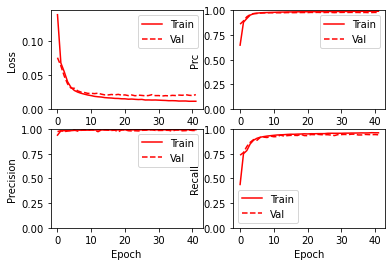

In [420]:
plot_metrics(history)

In [421]:
y_2_pred=nnmodel.predict(X_2)>0.5

In [423]:
y_2_pred=y_2_pred.astype(int)

In [424]:
print(confusion_matrix(y_2,y_2_pred))

[[658203  48548]
 [ 23285  29302]]


In [425]:
y_val_pred=(nnmodel.predict(X_val)>0.5).astype(int)

In [426]:
print(confusion_matrix(y_val,y_val_pred))

[[248343    247]
 [   973  16650]]


We ran into something very strange here. When we split the training set into train and validation data, the model performed very well on the validation set held out, but did very poorly on the separate test data , in particular on the positive class where more than half were false negatives. We can see how we do if we train on the whole training set and validate on the test data

In [427]:
history2=nnmodel.fit(X_1,y_1,epochs=50,batch_size=2048,callbacks=[early_stopping],validation_data=(X_2,y_2))

Epoch 1/50
434/434 [==============================] - 5s 10ms/step - loss: 76.4166 - tp: 44759.0000 - fp: 14669.0000 - tn: 813886.0000 - fn: 14060.0000 - accuracy: 0.9676 - precision: 0.7532 - recall: 0.7610 - auc: 0.8719 - prc: 0.6165 - val_loss: 24.8716 - val_tp: 38311.0000 - val_fp: 47538.0000 - val_tn: 659213.0000 - val_fn: 14276.0000 - val_accuracy: 0.9186 - val_precision: 0.4463 - val_recall: 0.7285 - val_auc: 0.8316 - val_prc: 0.3687
Epoch 2/50
434/434 [==============================] - 2s 6ms/step - loss: 11.7054 - tp: 45751.0000 - fp: 13932.0000 - tn: 814623.0000 - fn: 13068.0000 - accuracy: 0.9696 - precision: 0.7666 - recall: 0.7778 - auc: 0.8813 - prc: 0.6434 - val_loss: 21.4072 - val_tp: 39321.0000 - val_fp: 83131.0000 - val_tn: 623620.0000 - val_fn: 13266.0000 - val_accuracy: 0.8731 - val_precision: 0.3211 - val_recall: 0.7477 - val_auc: 0.8169 - val_prc: 0.2780
Epoch 3/50
434/434 [==============================] - 3s 6ms/step - loss: 7.6059 - tp: 46008.0000 - fp: 13560.0

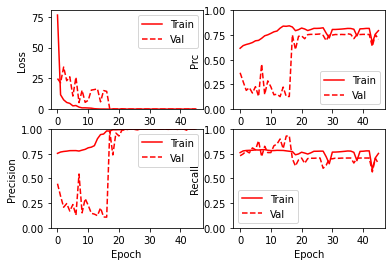

In [428]:
plot_metrics(history2)

In [429]:
y_2_pred=(nnmodel.predict(X_2)>0.5).astype(int)

In [430]:
print(confusion_matrix(y_2,y_2_pred))

[[706742      9]
 [ 15462  37125]]


In [431]:
print(classification_report(y_2,y_2_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    706751
           1       1.00      0.71      0.83     52587

    accuracy                           0.98    759338
   macro avg       0.99      0.85      0.91    759338
weighted avg       0.98      0.98      0.98    759338



In [432]:
roc_auc_score(y_2,y_2_pred)

0.852980112383504

In [433]:
y_2_pred=nnmodel.predict(X_2)

In [434]:
conf=[]
for p in np.arange(0.05,0.95,0.05):
    pred=(y_2_pred>p).astype(int)
    print("Threshold : ",p)
    print(confusion_matrix(y_2,pred))
    conf.append([p,confusion_matrix(y_2,pred)])

Threshold :  0.05
[[706673     78]
 [ 15458  37129]]
Threshold :  0.1
[[706713     38]
 [ 15459  37128]]
Threshold :  0.15000000000000002
[[706724     27]
 [ 15460  37127]]
Threshold :  0.2
[[706728     23]
 [ 15461  37126]]
Threshold :  0.25
[[706729     22]
 [ 15461  37126]]
Threshold :  0.3
[[706736     15]
 [ 15462  37125]]
Threshold :  0.35000000000000003
[[706736     15]
 [ 15462  37125]]
Threshold :  0.4
[[706739     12]
 [ 15462  37125]]
Threshold :  0.45
[[706739     12]
 [ 15462  37125]]
Threshold :  0.5
[[706742      9]
 [ 15462  37125]]
Threshold :  0.55
[[706743      8]
 [ 15462  37125]]
Threshold :  0.6000000000000001
[[706746      5]
 [ 15462  37125]]
Threshold :  0.6500000000000001
[[706747      4]
 [ 15462  37125]]
Threshold :  0.7000000000000001
[[706748      3]
 [ 15462  37125]]
Threshold :  0.7500000000000001
[[706749      2]
 [ 15463  37124]]
Threshold :  0.8
[[706749      2]
 [ 15463  37124]]
Threshold :  0.8500000000000001
[[706749      2]
 [ 15463  37124]]
Thres

In [437]:
from sklearn.metrics import roc_curve

In [438]:
est=grid2_rf_balanced_accuracy.best_estimator_

In [439]:
est.fit(X_1,y_1)

RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=150)

In [440]:
from sklearn.metrics import plot_roc_curve,plot_precision_recall_curve

C:\Users\ronsp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


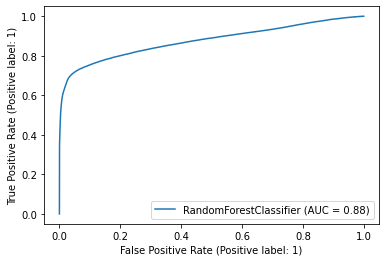

In [445]:
plot_roc_curve(est,X_2,y_2)

In [442]:
fpr_keras,tpr_keras,thresh_keras=roc_curve(y_2,y_2_pred)

In [443]:
from sklearn.metrics import auc
auc(fpr_keras,tpr_keras)

0.8742898723200883

<function matplotlib.pyplot.show(close=None, block=None)>

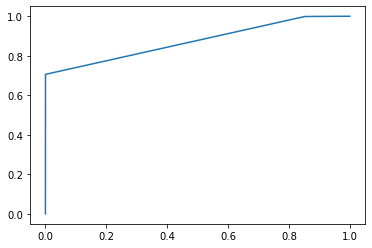

In [446]:
plt.plot(fpr_keras,tpr_keras)
plt.show

C:\Users\ronsp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


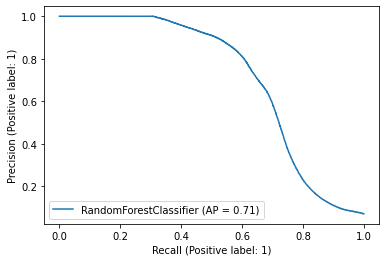

In [447]:
plot_precision_recall_curve(est,X_2,y_2)

C:\Users\ronsp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\ronsp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


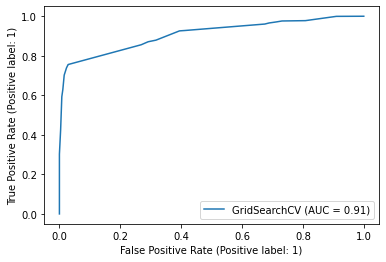

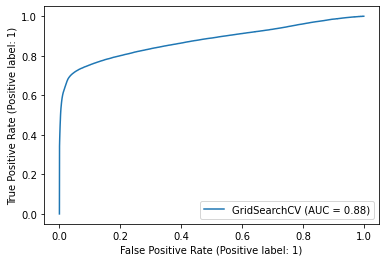

In [448]:
plot_roc_curve(grid_lgbm,X_2,y_2)
plot_roc_curve(grid2_rf_balanced_accuracy,X_2,y_2)
plt.show()

In [ ]:
!pip install -U imbalanced-learn

We want to see how resampling does compared to using weights on the target values. To start we try a simple random oversampler and see how it performs

In [449]:
from imblearn.over_sampling import RandomOverSampler

In [450]:
ros=RandomOverSampler(random_state=123)


In [451]:
X_resampled,y_resampled=ros.fit_resample(X_1,y_1)

In [452]:
#We can check to see that this is now balanced
y_resampled.sum()/len(y_resampled)

0.5

In [453]:
#Try training a random forest classifer using gridsearch on the resampled data
grid_rf_resampled=GridSearchCV(RandomForestClassifier(),params)
grid_rf_resampled.fit(X_resampled,y_resampled)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [2, 5, 10, None],
                         'n_estimators': [50, 100, 150, 200]})

In [454]:
grid_rf_resampled.best_params_

{'class_weight': 'balanced', 'max_depth': 2, 'n_estimators': 50}

In [455]:
y_2_pred=grid_rf_resampled.predict(X_2)

In [456]:
print(classification_report(y_2,y_2_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96    706751
           1       0.48      0.63      0.54     52587

    accuracy                           0.93    759338
   macro avg       0.73      0.79      0.75    759338
weighted avg       0.94      0.93      0.93    759338



In [457]:
print(confusion_matrix(y_2,y_2_pred))

[[670979  35772]
 [ 19496  33091]]


We didn't get any real improvement this way. Our next steps are to try a little feature engineering, run a model on that. We can then look at feature importances and pick only the really most important features and develop a model off of those

In [458]:
X_1.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'pymnt_plan', 'dti',
       ...
       'emp_labels_emp_label0', 'emp_labels_emp_label1',
       'emp_labels_emp_label2', 'emp_labels_emp_label3',
       'emp_labels_emp_label4', 'emp_labels_emp_label5',
       'emp_labels_emp_label6', 'emp_labels_emp_label7',
       'emp_labels_emp_label8', 'emp_labels_emp_label9'],
      dtype='object', length=132)

In [459]:
X_1.dtypes

loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
term                       int64
int_rate                 float64
                          ...   
emp_labels_emp_label5      uint8
emp_labels_emp_label6      uint8
emp_labels_emp_label7      uint8
emp_labels_emp_label8      uint8
emp_labels_emp_label9      uint8
Length: 132, dtype: object

In [460]:
X_1[["loan_amnt","funded_amnt","funded_amnt_inv"]].head()

,loan_amnt,funded_amnt,funded_amnt_inv
0,5000.0,5000.0,4975.0
1,2500.0,2500.0,2500.0
2,2400.0,2400.0,2400.0
3,10000.0,10000.0,10000.0
4,3000.0,3000.0,3000.0


In [461]:
X_1[X_1.loan_amnt!=X_1.funded_amnt].head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,pymnt_plan,dti,...,emp_labels_emp_label0,emp_labels_emp_label1,emp_labels_emp_label2,emp_labels_emp_label3,emp_labels_emp_label4,emp_labels_emp_label5,emp_labels_emp_label6,emp_labels_emp_label7,emp_labels_emp_label8,emp_labels_emp_label9
61,17500.0,8950.0,8925.0,60,17.27,223.74,6.0,40000.0,0,19.47,...,0,0,0,0,0,0,0,1,0,0
66,12500.0,8925.0,8925.0,60,17.27,223.11,5.0,30000.0,0,13.16,...,1,0,0,0,0,0,0,0,0,0
70,20975.0,13575.0,13550.0,60,17.58,341.63,5.0,44000.0,0,18.79,...,1,0,0,0,0,0,0,0,0,0
77,7250.0,7200.0,7175.0,60,21.67,197.51,0.0,75000.0,0,24.82,...,1,0,0,0,0,0,0,0,0,0
80,35000.0,22075.0,22050.0,60,17.27,551.84,3.0,150000.0,0,7.51,...,1,0,0,0,0,0,0,0,0,0


In [462]:
#Features comparing how much got requested, how much got funded, how much got funded by investors
X_1["loan_not_funded"]=X_1.loan_amnt-X_1.funded_amnt
X_1["funded_not_inv"]=X_1.funded_amnt-X_1.funded_amnt_inv
X_2["loan_not_funded"]=X_2.loan_amnt-X_2.funded_amnt
X_2["funded_not_inv"]=X_2.funded_amnt-X_2.funded_amnt_inv


C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/2559749191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["loan_not_funded"]=X_1.loan_amnt-X_1.funded_amnt
C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/2559749191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["funded_not_inv"]=X_1.funded_amnt-X_1.funded_amnt_inv
C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/2559749191.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [463]:
X_1.loan_not_funded.describe()

count    887374.000000
mean         13.387056
std         323.882416
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       21150.000000
Name: loan_not_funded, dtype: float64

In [464]:
X_1.funded_not_inv.describe()

count    887374.000000
mean         39.413464
std         530.324525
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       32474.996081
Name: funded_not_inv, dtype: float64

In [465]:
#Relative amount of the debt compared to their total current debt
X_1["loan_to_debt_ratio"]=X_1.funded_amnt/X_1.tot_cur_bal
X_2["loan_to_debt_ratio"]=X_2.funded_amnt/X_1.tot_cur_bal

C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/1285862364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["loan_to_debt_ratio"]=X_1.funded_amnt/X_1.tot_cur_bal
C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/1285862364.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2["loan_to_debt_ratio"]=X_2.funded_amnt/X_1.tot_cur_bal


In [466]:
#Ratio of amount funded to annual income
X_1["loan_to_inc_ratio"]=X_1.funded_amnt/X_1.annual_inc
X_2["loan_to_inc_ratio"]=X_2.funded_amnt/X_2.annual_inc

C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/702812334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["loan_to_inc_ratio"]=X_1.funded_amnt/X_1.annual_inc
C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/702812334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2["loan_to_inc_ratio"]=X_2.funded_amnt/X_2.annual_inc


In [467]:
#Ratio of funded amount to amount requested
X_1["funded_to_req_ratio"]=X_1.funded_amnt/X_1.loan_amnt
X_2["funded_to_req_ratio"]=X_2.funded_amnt/X_2.loan_amnt

C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/1186150952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["funded_to_req_ratio"]=X_1.funded_amnt/X_1.loan_amnt
C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/1186150952.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2["funded_to_req_ratio"]=X_2.funded_amnt/X_2.loan_amnt


In [468]:
#Ratio of outstanding principal to amount funded
X_1["amount_left_ratio"]=X_1.out_prncp/X_1.funded_amnt
X_2["amount_left_ratio"]=X_2.out_prncp/X_2.funded_amnt

C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/413572152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["amount_left_ratio"]=X_1.out_prncp/X_1.funded_amnt
C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/413572152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2["amount_left_ratio"]=X_2.out_prncp/X_2.funded_amnt


In [469]:
#How much of their payments have gone towards principal
X_1["ratio_of_payments_to_principal"]=X_1.total_rec_prncp/X_1.total_pymnt
X_2["ratio_of_payments_to_principal"]=X_2.total_rec_prncp/X_2.total_pymnt

C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/2306949299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["ratio_of_payments_to_principal"]=X_1.total_rec_prncp/X_1.total_pymnt
C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/2306949299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2["ratio_of_payments_to_principal"]=X_2.total_rec_prncp/X_2.total_pymnt


In [470]:
#What fraction of delinquincies in the past 2 years are current
X_1["ratio_of_recent_delinq_current"]=X_1.acc_now_delinq/X_1.delinq_2yrs
X_2["ratio_of_recent_delinq_current"]=X_2.acc_now_delinq/X_1.delinq_2yrs

C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/4238266529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["ratio_of_recent_delinq_current"]=X_1.acc_now_delinq/X_1.delinq_2yrs
C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/4238266529.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2["ratio_of_recent_delinq_current"]=X_2.acc_now_delinq/X_1.delinq_2yrs


In [471]:
#If there were no deliquencies at all in the last two years , use 0
X_1.ratio_of_recent_delinq_current.fillna(0,inplace=True)
X_2.ratio_of_recent_delinq_current.fillna(0,inplace=True)

C:\Users\ronsp\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [472]:
for col in X_1.columns:
    if X_1[col].isna().sum()>0:
        print(col)

ratio_of_payments_to_principal


In [473]:
for col in X_2.columns:
    if X_2[col].isna().sum()>0:
        print(col)

loan_to_debt_ratio
ratio_of_payments_to_principal


In [474]:
#This column has values of "NaN" from situations where the debt before was 0, so we get rid of it
X_1.drop(columns=["loan_to_debt_ratio"],inplace=True)
X_2.drop(columns=["loan_to_debt_ratio"],inplace=True)

C:\Users\ronsp\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [475]:
#Replace the one dropped with the ratio in reverse. There is always some funded amount
X_1["debt_to_loan_ratio"]=X_1.tot_cur_bal/X_1.funded_amnt
X_2["debt_to_loan_ratio"]=X_2.tot_cur_bal/X_2.funded_amnt

C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/964192816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["debt_to_loan_ratio"]=X_1.tot_cur_bal/X_1.funded_amnt
C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/964192816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2["debt_to_loan_ratio"]=X_2.tot_cur_bal/X_2.funded_amnt


In [476]:
X_1[X_1.ratio_of_payments_to_principal.isna()][["total_rec_prncp","total_pymnt"]].value_counts()

total_rec_prncp  total_pymnt
0.0              0.0            17758
dtype: int64

In [477]:
#For loans with no payments yet, call it 100% towards principal
X_1.ratio_of_payments_to_principal.fillna(1,inplace=True)
X_2.ratio_of_payments_to_principal.fillna(1,inplace=True)

In [478]:
#How much of the annual income goes to each installment
X_1["install_to_inc_ratio"]=X_1.installment/X_1.annual_inc
X_2["install_to_inc_ratio"]=X_2.installment/X_2.annual_inc

C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/2048153673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["install_to_inc_ratio"]=X_1.installment/X_1.annual_inc
C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/2048153673.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2["install_to_inc_ratio"]=X_2.installment/X_2.annual_inc


In [479]:
#How much of the current balance is revolving debt
X_1["rev_debt_ratio"]=X_1.revol_bal/X_1.tot_cur_bal
X_2["rev_debt_ratio"]=X_2.revol_bal/X_1.tot_cur_bal
#For no current balance call the ratio 0
X_1.rev_debt_ratio.fillna(0,inplace=True)
X_2.rev_debt_ratio.fillna(0,inplace=True)
X_1.rev_debt_ratio.replace(np.inf,0,inplace=True)
X_2.rev_debt_ratio.replace(np.inf,0,inplace=True)

C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/573377344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["rev_debt_ratio"]=X_1.revol_bal/X_1.tot_cur_bal
C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/573377344.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2["rev_debt_ratio"]=X_2.revol_bal/X_1.tot_cur_bal
C:\Users\ronsp\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [480]:
#ratio of interest paid to total payments
X_1["ratio_of_int_pay"]=X.total_rec_int/X.total_pymnt
X_2["ratio_of_int_pay"]=X.total_rec_int/X.total_pymnt
#set this to zero for people who haven't made payments yet
X_1.ratio_of_int_pay.fillna(0,inplace=True)
X_2.ratio_of_int_pay.fillna(0,inplace=True)


C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/2770791642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["ratio_of_int_pay"]=X.total_rec_int/X.total_pymnt
C:\Users\ronsp\AppData\Local\Temp/ipykernel_39244/2770791642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2["ratio_of_int_pay"]=X.total_rec_int/X.total_pymnt


Now that we have some more features that might be useful we rerun to get a new model. We'll look at both random forest and lightgbm, and look at the features that were important in each to try to restrict to those

In [481]:
grid_rf_3=GridSearchCV(RandomForestClassifier(),params,scoring="balanced_accuracy")
grid_rf_3.fit(X_1,y_1)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [2, 5, 10, None],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='balanced_accuracy')

In [482]:
grid_rf_3.best_params_

{'class_weight': 'balanced', 'max_depth': 2, 'n_estimators': 200}

In [483]:
grid_rf_3.best_score_

0.8348776121868664

In [485]:
for col in X_2.columns:
    if X_2[col].isna().sum()>0:
        print(col," has null values")
    if np.inf in X_2[col].unique():
        print(col," has infinite values")

ratio_of_recent_delinq_current  has infinite values


In [486]:
X_2.ratio_of_recent_delinq_current.replace(np.inf,0,inplace=True)

C:\Users\ronsp\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [487]:
y_2_pred=grid_rf_3.predict(X_2)

In [488]:
print(confusion_matrix(y_2,y_2_pred))

[[690690  16061]
 [ 15952  36635]]


In [489]:
grid_rf_3.best_estimator_.feature_importances_

array([9.72293916e-06, 8.33610983e-05, 2.29142261e-04, 7.79968816e-04,
       3.64154211e-02, 7.78695977e-06, 0.00000000e+00, 3.87885870e-03,
       0.00000000e+00, 3.18956108e-04, 0.00000000e+00, 1.92365765e-03,
       2.36217371e-05, 8.44679151e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.80808367e-03, 0.00000000e+00, 2.15521361e-02,
       1.16750762e-01, 1.33598660e-01, 6.57782564e-03, 1.28250866e-02,
       3.02011929e-02, 1.01952033e-02, 2.22891464e-02, 9.04483936e-02,
       7.60317452e-02, 4.14604976e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.09080092e-14, 1.43256817e-04, 1.15430664e-02,
       3.98175146e-03, 6.88135949e-02, 9.01187278e-03, 1.75313330e-04,
       5.32392951e-02, 6.82939439e-04, 2.81395084e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.69793249e-03, 7.49243437e-05, 1.37420851e-04, 5.14976089e-04,
       3.75206895e-06, 4.13455287e-04, 0.00000000e+00, 1.46080666e-14,
      

In [490]:
grid_3_features=pd.DataFrame([X_1.columns,grid_rf_3.best_estimator_.feature_importances_],index=['feature','importance'])

In [491]:
features=grid_3_features.T.sort_values('importance',ascending=False)

In [492]:
features.head()

,feature,importance
21,out_prncp_inv,0.133599
20,out_prncp,0.116751
27,recoveries,0.090448
28,collection_recovery_fee,0.076032
136,amount_left_ratio,0.074068


In [493]:
features["cumulative importance"]=features.importance.cumsum()

In [494]:
features.head()

,feature,importance,cumulative importance
21,out_prncp_inv,0.133599,0.133599
20,out_prncp,0.116751,0.250349
27,recoveries,0.090448,0.340798
28,collection_recovery_fee,0.076032,0.41683
136,amount_left_ratio,0.074068,0.490897


In [495]:
features.head(10)

,feature,importance,cumulative importance
21,out_prncp_inv,0.133599,0.133599
20,out_prncp,0.116751,0.250349
27,recoveries,0.090448,0.340798
28,collection_recovery_fee,0.076032,0.41683
136,amount_left_ratio,0.074068,0.490897
137,ratio_of_payments_to_principal,0.068935,0.559833
37,last_credit_pull_d,0.068814,0.628646
40,next_pymnt_d,0.053239,0.681886
29,last_pymnt_amnt,0.04146,0.723346
4,int_rate,0.036415,0.759762


In [496]:
features.head(15)

,feature,importance,cumulative importance
21,out_prncp_inv,0.133599,0.133599
20,out_prncp,0.116751,0.250349
27,recoveries,0.090448,0.340798
28,collection_recovery_fee,0.076032,0.41683
136,amount_left_ratio,0.074068,0.490897
137,ratio_of_payments_to_principal,0.068935,0.559833
37,last_credit_pull_d,0.068814,0.628646
40,next_pymnt_d,0.053239,0.681886
29,last_pymnt_amnt,0.04146,0.723346
4,int_rate,0.036415,0.759762


In [497]:
feature_list=list(features['feature'][:13])

In [498]:
len(feature_list)

13

In [499]:
feature_list

['out_prncp_inv',
 'out_prncp',
 'recoveries',
 'collection_recovery_fee',
 'amount_left_ratio',
 'ratio_of_payments_to_principal',
 'last_credit_pull_d',
 'next_pymnt_d',
 'last_pymnt_amnt',
 'int_rate',
 'ratio_of_int_pay',
 'total_rec_prncp',
 'fine_grade']

Before trimming down the list of features, lets see what happens with LightGBM

In [500]:
grid_2_lgbm=GridSearchCV(lgb.LGBMClassifier(),lgbmparams,scoring='balanced_accuracy')

In [502]:
grid_2_lgbm.fit(X_1,y_1)

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [1, 2, 4, -1],
                         'n_estimators': [50, 100, 150, 200],
                         'num_leaves': [10, 20, 30, 40],
                         'reg_alpha': [0, 0.01, 0.1],
                         'reg_lambda': [0, 0.01, 0.1]},
             scoring='balanced_accuracy')

In [503]:
grid_2_lgbm.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 200,
 'num_leaves': 10,
 'reg_alpha': 0,
 'reg_lambda': 0}

In [504]:
grid_2_lgbm.best_score_

0.8514921712846034

In [505]:
grid_2_lgbm.best_estimator_.feature_importances_

array([  0,   0,   0,   0,  15,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 123,   0,   0,   0,   0,   0,
        44,  77,   0,  78,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,  76,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 187,   0,   0,   0,   0,   0])

In [506]:
lgbm_features=pd.DataFrame([X_1.columns,grid_2_lgbm.best_estimator_.feature_importances_],index=["features","importance"]).T.sort_values("importance",ascending=False)

In [507]:
lgbm_features["cumulative_importance"]=lgbm_features.importance.cumsum()/lgbm_features.importance.sum()

In [508]:
lgbm_features.head(13)

,features,importance,cumulative_importance
137,ratio_of_payments_to_principal,187,0.311667
20,out_prncp,123,0.516667
29,last_pymnt_amnt,78,0.646667
27,recoveries,77,0.775
40,next_pymnt_d,76,0.901667
26,total_rec_late_fee,44,0.975
4,int_rate,15,1.0
105,addr_state_RI,0,1.0
104,addr_state_PA,0,1.0
103,addr_state_OR,0,1.0


In [509]:
lgbm_feature_list=list(lgbm_features.features.head(7))

In [510]:
lgbm_feature_list

['ratio_of_payments_to_principal',
 'out_prncp',
 'last_pymnt_amnt',
 'recoveries',
 'next_pymnt_d',
 'total_rec_late_fee',
 'int_rate']

In [511]:
set(feature_list).difference(set(lgbm_feature_list))

{'amount_left_ratio',
 'collection_recovery_fee',
 'fine_grade',
 'last_credit_pull_d',
 'out_prncp_inv',
 'ratio_of_int_pay',
 'total_rec_prncp'}

In [512]:
set(lgbm_feature_list).difference(set(feature_list))

{'total_rec_late_fee'}

In [513]:
features[features.feature=="total_rec_late_fee"]

,feature,importance,cumulative importance
26,total_rec_late_fee,0.022289,0.87426


In [514]:
y_2_lgbm_pred=grid_2_lgbm.predict(X_2)

In [515]:
print(classification_report(y_2,y_2_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    706751
           1       0.70      0.70      0.70     52587

    accuracy                           0.96    759338
   macro avg       0.84      0.84      0.84    759338
weighted avg       0.96      0.96      0.96    759338



In [516]:
print(classification_report(y_2,y_2_lgbm_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    706751
           1       0.89      0.71      0.79     52587

    accuracy                           0.97    759338
   macro avg       0.94      0.85      0.89    759338
weighted avg       0.97      0.97      0.97    759338



In [517]:
print(confusion_matrix(y_2,y_2_lgbm_pred))

[[702376   4375]
 [ 15447  37140]]


In [518]:
feature_list.append('total_rec_late_fee')

In [519]:
X_train=X_1[feature_list]
X_test=X_2[feature_list]

In [520]:
X_train.columns

Index(['out_prncp_inv', 'out_prncp', 'recoveries', 'collection_recovery_fee',
       'amount_left_ratio', 'ratio_of_payments_to_principal',
       'last_credit_pull_d', 'next_pymnt_d', 'last_pymnt_amnt', 'int_rate',
       'ratio_of_int_pay', 'total_rec_prncp', 'fine_grade',
       'total_rec_late_fee'],
      dtype='object')

In [521]:
X_train.head()

,out_prncp_inv,out_prncp,recoveries,collection_recovery_fee,amount_left_ratio,ratio_of_payments_to_principal,last_credit_pull_d,next_pymnt_d,last_pymnt_amnt,int_rate,ratio_of_int_pay,total_rec_prncp,fine_grade,total_rec_late_fee
0,0.0,0.0,0.00,0.00,0.000000,0.853086,1492.0,306.0,171.62,10.65,0.146913,5000.00,28,0.00
1,0.0,0.0,117.08,1.11,0.000000,0.452519,640.0,306.0,119.66,15.27,0.431412,456.46,21,0.00
2,0.0,0.0,0.00,0.00,0.000000,0.799027,1492.0,306.0,649.91,15.96,0.200972,2400.00,20,0.00
3,0.0,0.0,0.00,0.00,0.000000,0.817909,1127.0,306.0,357.48,13.49,0.180703,10000.00,24,16.97
4,766.9,766.9,0.00,0.00,0.255633,0.688767,1492.0,1523.0,67.79,12.69,0.311233,2233.10,25,0.00


We've narrowed down the columns to use to 14. These accounted for the vast majority of feature importances in the Random Forest model and all of the non-zero feature importances in the LightGBM model. We now focus on these to see if filtering the others out improve our results.

In [522]:
grid_rf_reduced=GridSearchCV(RandomForestClassifier(),params,scoring="balanced_accuracy")

In [523]:
grid_rf_reduced.fit(X_train,y_1)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [2, 5, 10, None],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='balanced_accuracy')

In [524]:
grid_rf_reduced.best_params_

{'class_weight': 'balanced', 'max_depth': 2, 'n_estimators': 100}

In [525]:
grid_rf_reduced.best_score_

0.840506885386997

In [526]:
y_2_rf_red_pred=grid_rf_reduced.predict(X_test)

In [527]:
print(confusion_matrix(y_2,y_2_rf_red_pred))

[[698836   7915]
 [ 15731  36856]]


In [528]:
print(classification_report(y_2,y_2_rf_red_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    706751
           1       0.82      0.70      0.76     52587

    accuracy                           0.97    759338
   macro avg       0.90      0.84      0.87    759338
weighted avg       0.97      0.97      0.97    759338



In [529]:
grid_lgb_red=GridSearchCV(lgb.LGBMClassifier(),lgbmparams,scoring="balanced_accuracy")

In [530]:
grid_lgb_red.fit(X_train,y_1)

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [1, 2, 4, -1],
                         'n_estimators': [50, 100, 150, 200],
                         'num_leaves': [10, 20, 30, 40],
                         'reg_alpha': [0, 0.01, 0.1],
                         'reg_lambda': [0, 0.01, 0.1]},
             scoring='balanced_accuracy')

In [531]:
grid_lgb_red.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 200,
 'num_leaves': 10,
 'reg_alpha': 0,
 'reg_lambda': 0}

In [532]:
y_2_lgb_red_pred=grid_lgb_red.predict(X_test)

In [533]:
print(confusion_matrix(y_2,y_2_lgb_red_pred))

[[702376   4375]
 [ 15447  37140]]


In [534]:
print(classification_report(y_2,y_2_lgb_red_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    706751
           1       0.89      0.71      0.79     52587

    accuracy                           0.97    759338
   macro avg       0.94      0.85      0.89    759338
weighted avg       0.97      0.97      0.97    759338



In [535]:
print(roc_auc_score(y_2,y_2_rf_red_pred))

0.8448292456060121


In [536]:
print(roc_auc_score(y_2,y_2_lgb_red_pred))

0.850033950854043


We can now see how a neural network does using this reduced data set

In [537]:
#save the train,test set in case we want to go back to the unscaled
X_tr=X_train
X_te=X_test
ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)

In [538]:
red_nnmodel= keras.Sequential([
      keras.layers.Dense(
          50, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
red_nnmodel.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)
red_nnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                750       
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,901
Trainable params: 5,901
Non-trainable params: 0
_________________________________________________________________


In [539]:
history_red=red_nnmodel.fit(X_train,y_1,epochs=50,batch_size=2048,callbacks=[early_stopping],validation_data=(X_test,y_2))

Epoch 1/50
434/434 [==============================] - 3s 5ms/step - loss: 0.1176 - tp: 72208.0000 - fp: 8743.0000 - tn: 1526563.0000 - fn: 39198.0000 - accuracy: 0.9709 - precision: 0.8920 - recall: 0.6482 - auc: 0.8859 - prc: 0.7490 - val_loss: 0.2680 - val_tp: 35573.0000 - val_fp: 54642.0000 - val_tn: 652109.0000 - val_fn: 17014.0000 - val_accuracy: 0.9056 - val_precision: 0.3943 - val_recall: 0.6765 - val_auc: 0.8613 - val_prc: 0.6732
Epoch 2/50
434/434 [==============================] - 1s 3ms/step - loss: 0.0661 - tp: 44657.0000 - fp: 631.0000 - tn: 827924.0000 - fn: 14162.0000 - accuracy: 0.9833 - precision: 0.9861 - recall: 0.7592 - auc: 0.9643 - prc: 0.8847 - val_loss: 2.3238 - val_tp: 44725.0000 - val_fp: 387975.0000 - val_tn: 318776.0000 - val_fn: 7862.0000 - val_accuracy: 0.4787 - val_precision: 0.1034 - val_recall: 0.8505 - val_auc: 0.7512 - val_prc: 0.1691
Epoch 3/50
434/434 [==============================] - 1s 3ms/step - loss: 0.0396 - tp: 48761.0000 - fp: 771.0000 - tn:

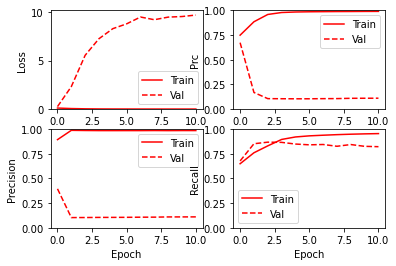

In [540]:
plot_metrics(history_red)

In [541]:
y_red_nn_pred=red_nnmodel.predict(X_test)>=0.5

In [542]:
print(confusion_matrix(y_2,y_red_nn_pred))

[[652109  54642]
 [ 17014  35573]]


In [543]:
print(classification_report(y_2,y_red_nn_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95    706751
           1       0.39      0.68      0.50     52587

    accuracy                           0.91    759338
   macro avg       0.68      0.80      0.72    759338
weighted avg       0.93      0.91      0.92    759338



Training this neural network on smaller set of features did worse. We can make an attempt with a deeper neural network

In [544]:
red_nnmodel_2= keras.Sequential([
      keras.layers.Dense(
          50, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
red_nnmodel_2.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)
red_nnmodel_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 50)                750       
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dense_13 (Dense)            (None, 50)                2550      
                                                                 
 dense_14 (Dense)            (None, 1)                

In [545]:
history_red_2=red_nnmodel_2.fit(X_train,y_1,epochs=50,batch_size=2048,callbacks=[early_stopping],validation_data=(X_test,y_2))

Epoch 1/50
434/434 [==============================] - 4s 6ms/step - loss: 0.0995 - tp: 82843.0000 - fp: 348407.0000 - tn: 1186899.0000 - fn: 28563.0000 - accuracy: 0.7711 - precision: 0.1921 - recall: 0.7436 - auc: 0.8053 - prc: 0.1797 - val_loss: 2.4636 - val_tp: 45214.0000 - val_fp: 420572.0000 - val_tn: 286179.0000 - val_fn: 7373.0000 - val_accuracy: 0.4364 - val_precision: 0.0971 - val_recall: 0.8598 - val_auc: 0.7528 - val_prc: 0.1736
Epoch 2/50
434/434 [==============================] - 2s 5ms/step - loss: 0.0363 - tp: 50611.0000 - fp: 1008.0000 - tn: 827547.0000 - fn: 8208.0000 - accuracy: 0.9896 - precision: 0.9805 - recall: 0.8605 - auc: 0.9880 - prc: 0.9582 - val_loss: 7.4533 - val_tp: 45654.0000 - val_fp: 405370.0000 - val_tn: 301381.0000 - val_fn: 6933.0000 - val_accuracy: 0.4570 - val_precision: 0.1012 - val_recall: 0.8682 - val_auc: 0.6630 - val_prc: 0.1018
Epoch 3/50
434/434 [==============================] - 2s 5ms/step - loss: 0.0234 - tp: 54021.0000 - fp: 1110.0000 - 

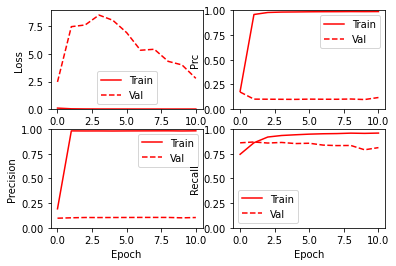

In [546]:
plot_metrics(history_red_2)

In [547]:
y_2_red_nn_2=red_nnmodel_2.predict(X_test)>=0.5

In [548]:
print(confusion_matrix(y_2,y_2_red_nn_2))

[[286179 420572]
 [  7373  45214]]


In [549]:
print(classification_report(y_2,y_2_red_nn_2))

              precision    recall  f1-score   support

           0       0.97      0.40      0.57    706751
           1       0.10      0.86      0.17     52587

    accuracy                           0.44    759338
   macro avg       0.54      0.63      0.37    759338
weighted avg       0.91      0.44      0.54    759338



Something odd happened here. The deeper network did a much better job on the positive class, but did a terrible job on the negative class. Possibly doing something in between would work better.

In [550]:
red_nnmodel_3= keras.Sequential([
      keras.layers.Dense(
          50, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dense(50, activation='relu'),
         keras.layers.Dense(1, activation='sigmoid')])
red_nnmodel_3.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)
red_nnmodel_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 50)                750       
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dense_17 (Dense)            (None, 50)                2550      
                                                                 
 dense_18 (Dense)            (None, 50)                2550      
                                                                 
 dense_19 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8,451
Trainable params: 8,451
Non-trainable params: 0
_________________________________________________________________


In [551]:
#first try the deeper network with no batch size set
history_nn_red_2=red_nnmodel_2.fit(X_train,y_1,epochs=50,callbacks=[early_stopping],validation_data=(X_test,y_2))

Epoch 1/50
27731/27731 [==============================] - 54s 2ms/step - loss: 0.0347 - tp: 51565.0000 - fp: 1510.0000 - tn: 827045.0000 - fn: 7254.0000 - accuracy: 0.9901 - precision: 0.9715 - recall: 0.8767 - auc: 0.9885 - prc: 0.9600 - val_loss: 3.6294 - val_tp: 43037.0000 - val_fp: 395248.0000 - val_tn: 311503.0000 - val_fn: 9550.0000 - val_accuracy: 0.4669 - val_precision: 0.0982 - val_recall: 0.8184 - val_auc: 0.6926 - val_prc: 0.1207
Epoch 2/50
27731/27731 [==============================] - 53s 2ms/step - loss: 0.0222 - tp: 54624.0000 - fp: 1439.0000 - tn: 827116.0000 - fn: 4195.0000 - accuracy: 0.9937 - precision: 0.9743 - recall: 0.9287 - auc: 0.9936 - prc: 0.9801 - val_loss: 8.5193 - val_tp: 42485.0000 - val_fp: 384303.0000 - val_tn: 322448.0000 - val_fn: 10102.0000 - val_accuracy: 0.4806 - val_precision: 0.0995 - val_recall: 0.8079 - val_auc: 0.6349 - val_prc: 0.0934
Epoch 3/50
27731/27731 [==============================] - 52s 2ms/step - loss: 0.0193 - tp: 55330.0000 - fp: 

In [552]:
y_pred_nn_red=red_nnmodel_2.predict(X_test)>0.5

In [553]:
print(confusion_matrix(y_2,y_pred_nn_red))

[[440455 266296]
 [ 14805  37782]]


In [554]:
history_nnmodel_red_3=red_nnmodel_3.fit(X_train,y_1,epochs=50,callbacks=[early_stopping],validation_data=(X_test,y_2))

Epoch 1/50
27731/27731 [==============================] - 51s 2ms/step - loss: 0.0368 - tp: 90601.0000 - fp: 349350.0000 - tn: 1185956.0000 - fn: 20805.0000 - accuracy: 0.7752 - precision: 0.2059 - recall: 0.8133 - auc: 0.8229 - prc: 0.1874 - val_loss: 4.4431 - val_tp: 43828.0000 - val_fp: 386238.0000 - val_tn: 320513.0000 - val_fn: 8759.0000 - val_accuracy: 0.4798 - val_precision: 0.1019 - val_recall: 0.8334 - val_auc: 0.6722 - val_prc: 0.1074
Epoch 2/50
27731/27731 [==============================] - 49s 2ms/step - loss: 0.0215 - tp: 54807.0000 - fp: 1474.0000 - tn: 827081.0000 - fn: 4012.0000 - accuracy: 0.9938 - precision: 0.9738 - recall: 0.9318 - auc: 0.9940 - prc: 0.9812 - val_loss: 8.7266 - val_tp: 43763.0000 - val_fp: 396512.0000 - val_tn: 310239.0000 - val_fn: 8824.0000 - val_accuracy: 0.4662 - val_precision: 0.0994 - val_recall: 0.8322 - val_auc: 0.6548 - val_prc: 0.1007
Epoch 3/50
27731/27731 [==============================] - 48s 2ms/step - loss: 0.0185 - tp: 55502.0000 - f

In [555]:
y_nn_red_3=red_nnmodel_3.predict(X_test)>=0.5

In [556]:
print(confusion_matrix(y_2,y_nn_red_3))

[[341230 365521]
 [  7913  44674]]


In [557]:
print(classification_report(y_2,y_nn_red_3))

              precision    recall  f1-score   support

           0       0.98      0.48      0.65    706751
           1       0.11      0.85      0.19     52587

    accuracy                           0.51    759338
   macro avg       0.54      0.67      0.42    759338
weighted avg       0.92      0.51      0.61    759338



In [558]:
grid_lgb_red

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [1, 2, 4, -1],
                         'n_estimators': [50, 100, 150, 200],
                         'num_leaves': [10, 20, 30, 40],
                         'reg_alpha': [0, 0.01, 0.1],
                         'reg_lambda': [0, 0.01, 0.1]},
             scoring='balanced_accuracy')

In [559]:
grid_lgb_red.best_estimator_

LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=2,
               n_estimators=200, num_leaves=10, reg_alpha=0, reg_lambda=0)

In [560]:
grid_2_lgbm.best_estimator_

LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=2,
               n_estimators=200, num_leaves=10, reg_alpha=0, reg_lambda=0)

In [584]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [587]:
def metrics(features,true_vals,threshhold=0.5):
    y_pred=grid_2_lgbm.predict_proba(features)[:,1]>=threshhold
    return confusion_matrix(true_vals,y_pred),precision_score(true_vals,y_pred),recall_score(true_vals,y_pred),f1_score(true_vals,y_pred)

In [602]:
thresh=[]
cm=[]
prec=[]
rec=[]
f1=[]

In [603]:
for p in np.arange(0.05,0.90,0.05):
    thresh.append(p)
    cmat,pr,re,f1s=metrics(X_2,y_2,p)
    cm.append(cmat)
    prec.append(pr)
    rec.append(re)
    f1.append(f1s)
    

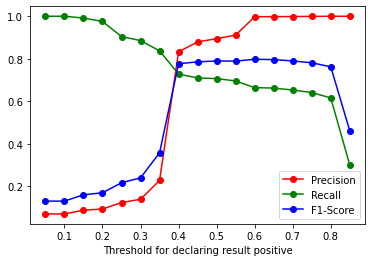

In [639]:
plt.plot(thresh,prec,color='r',marker='o')
plt.plot(thresh,rec,color='g',marker='o')
plt.plot(thresh,f1,color='b',marker='o')
plt.xlabel("Threshold for declaring result positive")
plt.legend(["Precision","Recall","F1-Score"])
plt.show()

In [617]:
metrics_df=pd.DataFrame([thresh,cm,prec,rec,f1],index=["Threshhold","Confusion Matrix","Precision","Recall","F1-Score"]).T

In [618]:
metrics_df.head()

,Threshhold,Confusion Matrix,Precision,Recall,F1-Score
0,0.05,"[[0, 706751], [0, 52587]]",0.069254,1.0,0.129537
1,0.1,"[[0, 706751], [0, 52587]]",0.069254,1.0,0.129537
2,0.15,"[[157013, 549738], [452, 52135]]",0.086621,0.991405,0.159322
3,0.2,"[[202621, 504130], [1285, 51302]]",0.092364,0.975564,0.168751
4,0.25,"[[366809, 339942], [5027, 47560]]",0.122735,0.904406,0.216138


In [620]:
metrics_df["F1-Score"].max()

0.7973554700435045

In [621]:
metrics_df[metrics_df["F1-Score"]==metrics_df["F1-Score"].max()]

,Threshhold,Confusion Matrix,Precision,Recall,F1-Score
11,0.6,"[[706676, 75], [17672, 34915]]",0.997857,0.663947,0.797355


In [624]:
metrics_df.sort_values("F1-Score",ascending=False).head(10)

,Threshhold,Confusion Matrix,Precision,Recall,F1-Score
11,0.6,"[[706676, 75], [17672, 34915]]",0.997857,0.663947,0.797355
12,0.65,"[[706684, 67], [17787, 34800]]",0.998078,0.661761,0.795847
13,0.7,"[[706708, 43], [18265, 34322]]",0.998749,0.652671,0.789447
9,0.5,"[[702376, 4375], [15447, 37140]]",0.894616,0.706258,0.789356
10,0.55,"[[703182, 3569], [16018, 36569]]",0.911082,0.6954,0.788762
8,0.45,"[[701610, 5141], [15272, 37315]]",0.87891,0.709586,0.785224
14,0.75,"[[706729, 22], [18891, 33696]]",0.999348,0.640767,0.780859
7,0.4,"[[699048, 7703], [14328, 38259]]",0.832405,0.727537,0.776446
15,0.8,"[[706746, 5], [20223, 32364]]",0.999846,0.615437,0.7619
16,0.85,"[[706751, 0], [36852, 15735]]",1.0,0.299218,0.460613


In [627]:
metrics_df.sort_values("Precision",ascending=False).head(10)

,Threshhold,Confusion Matrix,Precision,Recall,F1-Score
16,0.85,"[[706751, 0], [36852, 15735]]",1.0,0.299218,0.460613
15,0.8,"[[706746, 5], [20223, 32364]]",0.999846,0.615437,0.7619
14,0.75,"[[706729, 22], [18891, 33696]]",0.999348,0.640767,0.780859
13,0.7,"[[706708, 43], [18265, 34322]]",0.998749,0.652671,0.789447
12,0.65,"[[706684, 67], [17787, 34800]]",0.998078,0.661761,0.795847
11,0.6,"[[706676, 75], [17672, 34915]]",0.997857,0.663947,0.797355
10,0.55,"[[703182, 3569], [16018, 36569]]",0.911082,0.6954,0.788762
9,0.5,"[[702376, 4375], [15447, 37140]]",0.894616,0.706258,0.789356
8,0.45,"[[701610, 5141], [15272, 37315]]",0.87891,0.709586,0.785224
7,0.4,"[[699048, 7703], [14328, 38259]]",0.832405,0.727537,0.776446


In [628]:
metrics_df.sort_values("Recall",ascending=False).head(10)

,Threshhold,Confusion Matrix,Precision,Recall,F1-Score
0,0.05,"[[0, 706751], [0, 52587]]",0.069254,1.0,0.129537
1,0.1,"[[0, 706751], [0, 52587]]",0.069254,1.0,0.129537
2,0.15,"[[157013, 549738], [452, 52135]]",0.086621,0.991405,0.159322
3,0.2,"[[202621, 504130], [1285, 51302]]",0.092364,0.975564,0.168751
4,0.25,"[[366809, 339942], [5027, 47560]]",0.122735,0.904406,0.216138
5,0.3,"[[416285, 290466], [6030, 46557]]",0.138142,0.885333,0.238993
6,0.35,"[[556610, 150141], [8559, 44028]]",0.226751,0.837241,0.356855
7,0.4,"[[699048, 7703], [14328, 38259]]",0.832405,0.727537,0.776446
8,0.45,"[[701610, 5141], [15272, 37315]]",0.87891,0.709586,0.785224
9,0.5,"[[702376, 4375], [15447, 37140]]",0.894616,0.706258,0.789356


In [629]:
metrics_df["Precision Change"]=metrics_df.Precision.diff()

In [630]:
metrics_df.head()

,Threshhold,Confusion Matrix,Precision,Recall,F1-Score,Precision Change
0,0.05,"[[0, 706751], [0, 52587]]",0.069254,1.0,0.129537,NaN
1,0.1,"[[0, 706751], [0, 52587]]",0.069254,1.0,0.129537,0.0
2,0.15,"[[157013, 549738], [452, 52135]]",0.086621,0.991405,0.159322,0.017368
3,0.2,"[[202621, 504130], [1285, 51302]]",0.092364,0.975564,0.168751,0.005743
4,0.25,"[[366809, 339942], [5027, 47560]]",0.122735,0.904406,0.216138,0.030371


In [631]:
metrics_df.sort_values("Precision Change",ascending=False).head(10)

,Threshhold,Confusion Matrix,Precision,Recall,F1-Score,Precision Change
7,0.4,"[[699048, 7703], [14328, 38259]]",0.832405,0.727537,0.776446,0.605654
6,0.35,"[[556610, 150141], [8559, 44028]]",0.226751,0.837241,0.356855,0.088609
11,0.6,"[[706676, 75], [17672, 34915]]",0.997857,0.663947,0.797355,0.086775
8,0.45,"[[701610, 5141], [15272, 37315]]",0.87891,0.709586,0.785224,0.046505
4,0.25,"[[366809, 339942], [5027, 47560]]",0.122735,0.904406,0.216138,0.030371
2,0.15,"[[157013, 549738], [452, 52135]]",0.086621,0.991405,0.159322,0.017368
10,0.55,"[[703182, 3569], [16018, 36569]]",0.911082,0.6954,0.788762,0.016465
9,0.5,"[[702376, 4375], [15447, 37140]]",0.894616,0.706258,0.789356,0.015706
5,0.3,"[[416285, 290466], [6030, 46557]]",0.138142,0.885333,0.238993,0.015407
3,0.2,"[[202621, 504130], [1285, 51302]]",0.092364,0.975564,0.168751,0.005743


In [634]:
metrics_df["Recall Change"]=metrics_df.Recall.diff()
metrics_df["F1 Change"]=metrics_df["F1-Score"].diff()

In [635]:
metrics_df.sort_values("F1 Change",ascending=False).head(10)

,Threshhold,Confusion Matrix,Precision,Recall,F1-Score,Precision Change,Recall Change,F1 Change
7,0.4,"[[699048, 7703], [14328, 38259]]",0.832405,0.727537,0.776446,0.605654,-0.109704,0.419592
6,0.35,"[[556610, 150141], [8559, 44028]]",0.226751,0.837241,0.356855,0.088609,-0.048092,0.117862
4,0.25,"[[366809, 339942], [5027, 47560]]",0.122735,0.904406,0.216138,0.030371,-0.071158,0.047387
2,0.15,"[[157013, 549738], [452, 52135]]",0.086621,0.991405,0.159322,0.017368,-0.008595,0.029786
5,0.3,"[[416285, 290466], [6030, 46557]]",0.138142,0.885333,0.238993,0.015407,-0.019073,0.022855
3,0.2,"[[202621, 504130], [1285, 51302]]",0.092364,0.975564,0.168751,0.005743,-0.01584,0.009429
8,0.45,"[[701610, 5141], [15272, 37315]]",0.87891,0.709586,0.785224,0.046505,-0.017951,0.008777
11,0.6,"[[706676, 75], [17672, 34915]]",0.997857,0.663947,0.797355,0.086775,-0.031453,0.008593
9,0.5,"[[702376, 4375], [15447, 37140]]",0.894616,0.706258,0.789356,0.015706,-0.003328,0.004133
1,0.1,"[[0, 706751], [0, 52587]]",0.069254,1.0,0.129537,0.0,0.0,0.0


In [637]:
metrics_df.sort_values("Recall Change",ascending=False).head(10)

,Threshhold,Confusion Matrix,Precision,Recall,F1-Score,Precision Change,Recall Change,F1 Change
1,0.1,"[[0, 706751], [0, 52587]]",0.069254,1.0,0.129537,0.0,0.0,0.0
12,0.65,"[[706684, 67], [17787, 34800]]",0.998078,0.661761,0.795847,0.000222,-0.002187,-0.001509
9,0.5,"[[702376, 4375], [15447, 37140]]",0.894616,0.706258,0.789356,0.015706,-0.003328,0.004133
2,0.15,"[[157013, 549738], [452, 52135]]",0.086621,0.991405,0.159322,0.017368,-0.008595,0.029786
13,0.7,"[[706708, 43], [18265, 34322]]",0.998749,0.652671,0.789447,0.00067,-0.00909,-0.0064
10,0.55,"[[703182, 3569], [16018, 36569]]",0.911082,0.6954,0.788762,0.016465,-0.010858,-0.000594
14,0.75,"[[706729, 22], [18891, 33696]]",0.999348,0.640767,0.780859,0.000599,-0.011904,-0.008588
3,0.2,"[[202621, 504130], [1285, 51302]]",0.092364,0.975564,0.168751,0.005743,-0.01584,0.009429
8,0.45,"[[701610, 5141], [15272, 37315]]",0.87891,0.709586,0.785224,0.046505,-0.017951,0.008777
5,0.3,"[[416285, 290466], [6030, 46557]]",0.138142,0.885333,0.238993,0.015407,-0.019073,0.022855


C:\Users\ronsp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


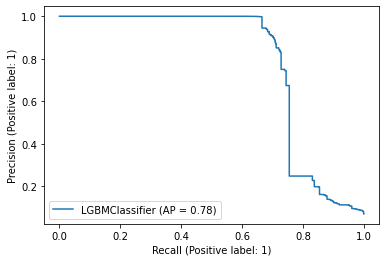

In [640]:
plot_precision_recall_curve(grid_2_lgbm.best_estimator_,X_2,y_2)
plt.show()

The method that seems to give us the best overall results is using the lightgbm model on our extended feature set with the features added, but using a threshold of 0.6 for the probability of being positive to declare it as positive. 